# **Machine Learning Applications Final Project Notebook**

Date: May 9, 2023

Authors: Óscar Montoya Amores (100451858), Javier Serrano Sánchez-Ocaña (100451673), Miguel Ángel Ponce Martínez (100451309)

#### **LIBRARIES IMPORT**

In [371]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy    

## **0. Dataset Loading and DF Preprocessing**

#### **DATASET IMPORT**

Let's load the dataset obtained from Kaggle (https://www.kaggle.com/datasets/elizzyliu/song-lyrics) and obtain the main insights from this data:

In [372]:
df = pd.read_csv('all_lyrics.csv')

display(df)

,song,artist,type,lyrics
0,Stairway to Heaven,Led Zeppelin,rock,Stairway to Heaven Lyrics[Intro]\r\n\r\n[Verse...
1,Hey Jude,Beatles,rock,Hey Jude Lyrics[Verse 1: Paul McCartney]\r\nHe...
2,All Along the Watchtower,"Hendrix, Jimi",rock,"Ii. Tambourine Lyrics[Chorus, sung]\r\nHey, Pi..."
3,Satisfaction,Rolling Stones,rock,"Sin título I Lyrics[Letra de ""Sin título I""]\r..."
4,Like A Rolling Stone,"Dylan, Bob",rock,Like a Rolling Stone Lyrics[Verse 1]\r\nOnce u...
...,...,...,...,...
3995,Motown 25,Elzhi,rap & hip hop,Motown 25 Lyrics[Verse 1: eLZhi]\r\nI end care...
3996,How Ya Like Me Now,Kool Moe Dee,rap & hip hop,"How Ya Like Me Now Lyrics""All aboard for the n..."
3997,Coastin’,Zion I feat. K.Flay,rap & hip hop,Coastin’ LyricsWhen life brings trouble\r\nYou...
3998,Head Banger,EPMD,rap & hip hop,Headbanger Lyrics[Redman]\r\nNegroes!!!!!!!!\r...


In [373]:
df.describe()

,song,artist,type,lyrics
count,4000,4000,4000,3896
unique,3881,1583,4,3761
top,Summertime,Beatles,rock,Summer Country Songs LyricsA\r\nAaron Lewis – ...
freq,5,51,1000,10


This dataset is composed by the 1000 most famous songs from every musical genre(``type Variable``) and our goal is find some relation among songs lyrics and its genre. 

Firstly, null values seems to appear in the lyrics row because as we can see 104 songs ``lyrics`` are not counted properly. So first thing wee need to do is remove null values.

Moreover, the unique row bothers us too. It is expected that ``type`` and ``artist`` have several instances repeated (Artist could have many famous songs and obviously given 4 genres it will be repeated). Furthermore, even two different artists could present two different songs with the same name (``song``). However, it is really strange that two songs represent the same lyrics. Here we could have be talking about plagiarism, corrupted data or simply describe() function is not working as expected with long string stucture, so before starting to apply some Machine Learnings Applicatios we have seen in class we need to fix this trouble.

In [374]:
null = df['lyrics'].isna().values

print(f'There are exactly {sum(null)} null values in the lyrics variable which corresponds to the {sum(null)/len(null)*100:.3f}% of the data set')


There are exactly 104 null values in the lyrics variable which corresponds to the 2.600% of the data set


We think this percentege is assumible of being removed from the dataset but before doing so let's see the proportion of songs genre which receives null lyrics. 

<Axes: >

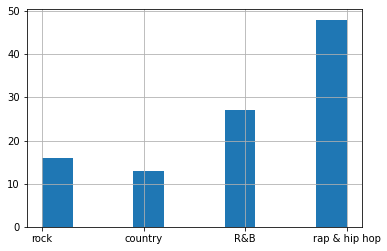

In [375]:
df_null = df[null]
df_null['type'].hist()

Most of the null lyrics are from ``rap & hip hop`` but nothing alarming. We can assume to remove this instances, update the dataframe and repeat a similar process to find out repeted lyrics. 

In [376]:
df = df.dropna(subset=['lyrics', 'type'])

In [377]:
print(df.duplicated().values)

[False False False ... False False False]


There are exactly 14 repeated values in the lyrics variable which corresponds to the 0.359% of the data set


<Axes: >

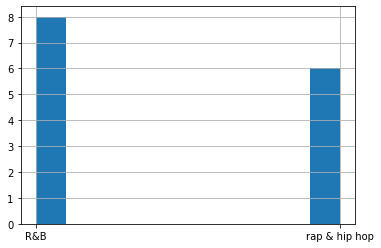

In [378]:
repeated = df[df.duplicated()]
print(f'There are exactly {len(repeated)} repeated values in the lyrics variable which corresponds to the {len(repeated)/len(df)*100:.3f}% of the data set')
repeated['type'].hist()

Again, the ammount of repeated values are not very important but this time is focused on only two genres. However, we will remove it because it is not adding any information and let's repeat the describe() process to finally start to focus on the Machine Learning Apps.

In [379]:
df = df.drop_duplicates(subset=['lyrics'], keep='first').reset_index(drop=True)
df.describe()

,song,artist,type,lyrics
count,3761,3761,3761,3761
unique,3668,1476,4,3761
top,Angel,Beatles,rock,Stairway to Heaven Lyrics[Intro]\r\n\r\n[Verse...
freq,5,48,972,1


Good news regarding the ``lyrics`` variable, is time to begin working with spacy and more NLP libaries we have seen during classes.

## **1. Text Preprocessing and vectorization**

### **1.1 NLP Pipeline**

Before the implementation of the Pipeline let's print some ``lyrics`` instances in order to visualize which kind of none useful set of characters has been introduced

In [380]:
instances = [l for l in df['lyrics'].values[:2]]

for si,s in enumerate(instances):
    print(f'SONG {si + 1}')
    print(str([s])+'\n')

SONG 1
["Stairway to Heaven Lyrics[Intro]\r\n\r\n[Verse 1]\r\nThere's a lady who's sure all that glitters is gold\r\nAnd she's buying a stairway to Heaven\r\nWhen she gets there she knows, if the stores are all closed\r\nWith a word she can get what she came for\r\nOoh, ooh, and she's buying a stairway to Heaven\r\nThere's a sign on the wall, but she wants to be sure\r\n'Cause you know sometimes words have two meanings\r\nIn a tree by the brook, there's a songbird who sings\r\nSometimes all of our thoughts are misgiven\r\n\r\n[Chorus]\r\nOoh, it  makes me wonder\r\nOoh, makes me wonder\r\n[Verse 2]\r\nThere's a feeling I get when I look to the West\r\nAnd my spirit is crying for leaving\r\nIn my thoughts I have seen rings of smoke through the trees\r\nAnd the voices of those who stand looking\r\n\r\n[Chorus]\r\nOoh, it makes me wonder\r\nOoh, really makes me wonder\r\n\r\n[Verse 3]\r\nAnd it's whispered that soon if we all call the tune\r\nThen the piper will lead us to reason\r\nAnd a

From these two songs we can clearly see that there are a lot of characters which is not necessary at all. Firstly it seems that at the beguining of every song, the title of the song it is included, an iformation wich is stored in other variable and we do not need. Also at the end of the song a sequence of numbers and 'Embed' word is appearing. Furthermore, every information inside '[]' is not corresponding to the lyrics itself. Finally, '/n' wich corresponds to line skip must be removed.

Regarding expresions like 'na', 'yeah', 'hey'... could be interpreted as some kind of stopword which maybe is not a word which express to much but especially in this second song for example it seems to be half of the song. So deppending on troubles we could face, we will change the decision of keeping this strings. However, contractions must be treated as a 'formal' word in orther to obtain the same meaning for every word. This can be counter benefit especially in ``rap & hip hop`` genre which most of the words uses contraction to fit with the rithm of the song. But at the end we are triying to find the meaning of the words in the song and each word must be represented in the same manner in every one.  

Creating a function to address all this problems would be the best manner to properly display the lyrics:

In [381]:
#Maximum length of any song's Title
lengthTitle = df['song'].apply(lambda x: len(x.split(' '))).values
maxLen = np.max(lengthTitle) + 5 #This 5 is just a margin just in case

In [382]:
import re
import contractions
import unicodedata

def correctLyrics(row, maxLen):
    text = row['lyrics']
    #1. Remove '\n' and Unicode Escape Sequence ('\u2005f)
    text =  re.sub(r'\n', ' ', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    #2. Remove '[]'
    text = re.sub(r'\[.*?\]', ' ', text)
    #3. Remove initial title + 'Lyrics' Keyword
    titleWords = text.split(' ')[:maxLen] #Save time and avoid errors
    restWords = text.split(' ')[maxLen:]
    titleWords = re.sub(r'.*?Lyrics', '', ' '.join(titleWords))
    text = titleWords + ' ' + ' '.join(restWords)
    #4. Remove 'Embed' at the end word of the song
    text = re.sub(r'\d+Embed|Embed', '', text)
    #5.Avoid more than 1 Espaces
    text = re.sub(r'\s+', ' ', text)
    #6. Remove contractions
    text = contractions.fix(text)
    return text

df['correctLyrics'] = df.apply(lambda x: correctLyrics(x,maxLen), axis=1)

display(df)

,song,artist,type,lyrics,correctLyrics
0,Stairway to Heaven,Led Zeppelin,rock,Stairway to Heaven Lyrics[Intro]\r\n\r\n[Verse...,There is a lady who is sure all that glitters...
1,Hey Jude,Beatles,rock,Hey Jude Lyrics[Verse 1: Paul McCartney]\r\nHe...,"Hey Jude, do not make it bad Take a sad song ..."
2,All Along the Watchtower,"Hendrix, Jimi",rock,"Ii. Tambourine Lyrics[Chorus, sung]\r\nHey, Pi...","Hey, Pip, play your tambourine Make the sailo..."
3,Satisfaction,Rolling Stones,rock,"Sin título I Lyrics[Letra de ""Sin título I""]\r...",Hay tres ninas jipis en la habitacion Una se ...
4,Like A Rolling Stone,"Dylan, Bob",rock,Like a Rolling Stone Lyrics[Verse 1]\r\nOnce u...,Once upon a time you dressed so fine Threw th...
...,...,...,...,...,...
3756,Motown 25,Elzhi,rap & hip hop,Motown 25 Lyrics[Verse 1: eLZhi]\r\nI end care...,"I end careers, years, pierce ears fierce with..."
3757,How Ya Like Me Now,Kool Moe Dee,rap & hip hop,"How Ya Like Me Now Lyrics""All aboard for the n...","""All aboard for the night train"" I throw my ta..."
3758,Coastin’,Zion I feat. K.Flay,rap & hip hop,Coastin’ LyricsWhen life brings trouble\r\nYou...,When life brings trouble You can fight or run ...
3759,Head Banger,EPMD,rap & hip hop,Headbanger Lyrics[Redman]\r\nNegroes!!!!!!!!\r...,"Negroes!!!!!!!! The head banger, WHAT? The he..."


After all these modifications let's see if the previous songs lyrics has an uniform structure: 

In [383]:
instances = [l for l in df['correctLyrics'].values[:2]]

for si,s in enumerate(instances):
    print(f'SONG {si + 1}')
    print(str([s])+'\n')

SONG 1
[" There is a lady who is sure all that glitters is gold And she is buying a stairway to Heaven When she gets there she knows, if the stores are all closed With a word she can get what she came for Ooh, ooh, and she is buying a stairway to Heaven There is a sign on the wall, but she wants to be sure Because you know sometimes words have two meanings In a tree by the brook, there is a songbird who sings Sometimes all of our thoughts are misgiven Ooh, it makes me wonder Ooh, makes me wonder There is a feeling I get when I look to the West And my spirit is crying for leaving In my thoughts I have seen rings of smoke through the trees And the voices of those who stand looking Ooh, it makes me wonder Ooh, really makes me wonder And it is whispered that soon if we all call the tune Then the piper will lead us to reason And a new day will dawn for those who stand long And the forests will echo with laughter Oh-oh-oh-oh-woahhh If there is a bustle in your hedgerow, do not be alarmed now

Now, these lyrics seems to be readable, escape sequences and Unicode elements has been removed, both title at the begining of the word and Embed at the has been also adressed. Finally, contractions has been recover onto its original verb. So far, so good.

However, something we need to know previously working with songs lyrics is that our dataset is about the 1000 most heard songs for every genre but this does not implies that all our songs are in the same language! Therefore, it would be useful to determine which language predominates for each song and in the case of minoritary languages, remove that instance because otherwise it would be impossible to asign a topic for these kind of sentences. Therefore, it is the moment to visualize which language priorises in this dataset and which other languages could surprise us.

In [384]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 33

def getLanguage(row):
    try:
        lan = detect(row['correctLyrics'])
    except:
        lan = 'uknwn'
    return lan

df['language'] = df.apply(getLanguage, axis = 1)

Surprisingly it only tooks less than one minute!. When we iniciate the process we were expecting 30 mins at list. This is not bad at all, now we can see which languages predominates in our dataset and this could be good information for a better interpretation of the number of topics we may need to select. Let's plot a histogram to visualize how this ``language`` variable is distributed.

<Axes: >

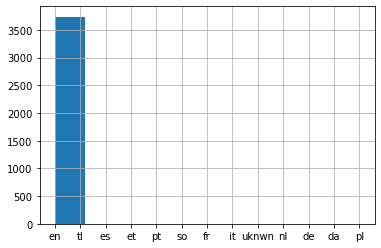

In [385]:
df['language'].hist()

Wow! Almost every song is in english. So, obviously this will be the main language in the corpus. However, let's put the spotlight in those minoritary languages, it does not seem that they include sufficient enough docs to perform a correct. Thus, let's focus now in this languages songs:

Tne number of non-english songs is 30 which correspond to 0.798% of the dataset


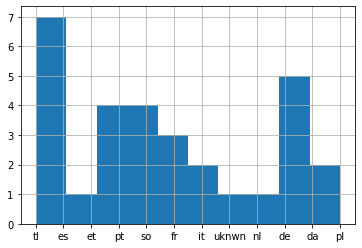

In [386]:
dfNoteng = df.loc[df['language'] != 'en']
dfNoteng['language'].hist()
print(f'Tne number of non-english songs is {dfNoteng.shape[0]} which correspond to {dfNoteng.shape[0]/df.shape[0]*100:.3f}% of the dataset')

It is less than a 1% of the total songs and the most repeated language is 'tagalog' which is a philipine language and are 7 instances of this language. Furthermore, one document is not recognized by the detector so it is classified as unknown. Therefore, it is assumable to loose these instances and after this deletion it is our time to apply our spicy Pipeline after the creation of the corpus.

In [387]:
df = df.loc[df['language'] == 'en'].reset_index(drop=True)

corpus = [elem for elem in df['correctLyrics']]

``corpus`` variable is composed by a long list including every song on it. We have done is in this way because we think Python lists for this kind of task would be faster than using Pandas Dataframes. From this we will create a Pipeline simiarily as we did in classes notebook and use further machine learning algorithm as final work statement requests.

Once the ``corpus`` has been created, it is very easy to apply a Pipeline:

In [388]:
from num2words import num2words
from tqdm import tqdm
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stopwords_en = stopwords.words('english')
wnl = WordNetLemmatizer()

valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN', 'NUM'])

def convertNum2words(token):
    try:
        return num2words(token)
    except:
        return token

def corpusPreprocessing(song):
    #1. Tokenization
    doc = wordpunct_tokenize(song)
    #2. Filtering by Alphanumeric and Lower the Text
    lowerToken = [token.lower() for token in doc if token.isalnum()]
    tokenList = [convertNum2words(token) for token in lowerToken]
    #3. Lemmatization of the data
    lemmaList = [wnl.lemmatize(el) for el in tokenList]
    #4. Cleanning StopWords
    finalCorpus = [lemma for lemma in lemmaList if lemma not in stopwords_en]
    return finalCorpus

corpus = [corpusPreprocessing(s) for s in tqdm(corpus)]

100%|██████████| 3731/3731 [00:36<00:00, 102.12it/s]


It is surprisingly fast compared to the Pipeline provided by SpaCy. In only took 33 seconds which is 10 times less than the previous Pipeline we constructed but we decided to rewrite it because of the lack of performance and .lower() was not available. 

### **1.2 Text Vectorization**

Now it is the moment of use N-Grams from ``gensim`` library in order to group in the same token those words that has a tendency of appear together:

In [389]:
from tqdm import tqdm
from gensim.models.phrases import Phrases

phrase_model = Phrases(corpus, min_count=2, threshold=20)

corpus = [el for el in tqdm(phrase_model[corpus])]

100%|██████████| 3731/3731 [00:02<00:00, 1413.51it/s]


Finally, in order to find a BoW and TF-IDF representation from our corpus, it is necessary to create previously a Gensim Dictionary where the songs will be stored. Once it is created, we can't include more instances, therefore this step is only made when the corpus has been finished.

In [390]:
from gensim.corpora import Dictionary

# Create dictionary of tokens
D = Dictionary(corpus)

print('Our dictionary contains', len(D), 'terms')

Our dictionary contains 78942 terms


Wow! more than 70000 terms in our diccionary. Compared to what we saw from IMBD dataset, this ones contains more items. However, this is not definitive, probably there are several terms that appears barely compared to from what we see in the IMBD which maybe follows a similar structure since a review could be good, bad but nothing else. Let's filter our Diccionary and we will see which are the real tokens that we will need to analyse:

In [391]:
D.filter_extremes(no_below=3,no_above=.80)

print('Our dictionary contains', len(D), 'terms')

Our dictionary contains 24464 terms


Now it makes sense, it decreased drastically and now it seems to be a good bunch of woords to work with. Now it is the moment to introduce clasical representations which using Gensim is quite easy:

In [392]:
from gensim.models import TfidfModel

bow_songs = [D.doc2bow(doc) for doc in corpus] #bow gensim corpus
tfidf = TfidfModel(bow_songs)
tfidf_songs = tfidf[bow_songs]

print('Hey Ya! - Outkast:')
print(corpus[2533])
print(bow_songs[2533])
print(tfidf_songs[2533])

Hey Ya! - Outkast:
['one', 'two', 'three', 'uh', 'baby', 'mess_around', 'love', 'know', 'sure', 'uh', 'doe', 'really', 'want', 'cannot', 'stand', 'see', 'walk', 'door', 'ah', 'try', 'fight', 'feeling', 'thought', 'alone', 'killing', 'right', 'uh', 'thank_god', 'mom_dad', 'sticking', 'two', 'together', 'know', 'c_mon', 'hey', 'ya', 'hey', 'ya', 'hey', 'ya', 'hey', 'ya', 'hey', 'ya', 'hey', 'ya', 'hey', 'ya', 'hey', 'ya', 'think', 'got', 'oh', 'think', 'got', 'got', 'get', 'till', 'nothing', 'ah', 'get', 'together', 'oh', 'get', 'together', 'separate', 'always', 'better', 'feeling', 'involved', 'ah', 'say', 'nothing', 'forever', 'make', 'make', 'make', 'make', 'make', 'make', 'love', 'exception', 'oh_oh', 'oh_oh', 'oh', 'denial', 'know', 'happy', 'want', 'hear', 'want', 'dance', 'hey', 'ya', 'uh', 'oh', 'hey', 'ya', 'uh', 'oh', 'want', 'meet', 'daddy', 'hey', 'ya', 'uh', 'oh', 'want', 'caddy', 'uh', 'oh', 'hey', 'ya', 'uh', 'oh', 'want', 'meet', 'mama', 'uh', 'oh', 'hey', 'ya', 'uh', 'oh

Therefore, this is our first figures obteinment from the words appearing in the lyrics song. Nevertheless, this is not enough to predict properly which genre our song has. This representation just considers the frequency of appearing but not the relation among words. For example, in this song ``Hey Ya! - Outkast``, word 'hey' which is some kind of musical onomatopoeia is repeated several times during the song, and its score is 0.53 in the TF-IDF representation which is really high despite it does not meaning anything the word by itself. But is not that bad, for example 'na' expresion could directly being related to ``R&B`` song, we do not know how the classification model will behave. Furthermore, these kind of representations will be very useful for the developement of more complex models focusing on different topics a song may present, thus it is essential to save them in a variable for future usages.

Without any more introduction, it is the moment to start developing further text-figure extraction models in order to obtain better insights from our data:

As our objective is to make a classification by genre, we will develop some more complex representations to work with.

So let's create first the representations:

#### **1.2.1 Word2Vec Representation**

##### **1.2.1.1 Word2Vec Representation with our Data**


From the corpus file in which we have all the lyrics cleaned and converted in tokens, we create the word2vec. 

We implement a seed to work in so we can keep track of the results. And we will try with a vector size of 200 for the embeeding size.

In [24]:
#WORD2VEC 

from gensim.models import Word2Vec

model_w2v = Word2Vec(corpus, vector_size=200, seed= 33)

Check the results of the word2vec:

In [25]:
words = list(model_w2v.wv.key_to_index)
print(words[0:50]) #first 50 words
print('\n============= Embedding of the first word =============')
print(model_w2v.wv[words[0]])
print(model_w2v.wv[words[0]].shape)

['wa', 'like', 'got', 'love', 'know', 'get', 'one', 'want', 'baby', 'time', 'go', 'would', 'come', 'see', 'going', 'make', 'oh', 'man', 'yeah', 'back', 'way', 'never', 'say', 'nigga', 'take', 'right', 'let', 'cannot', 'life', 'day', 'girl', 'good', 'could', 'thing', 'two', 'said', 'give', 'need', 'tell', 'feel', 'well', 'think', 'night', 'little', 'u', 'still', 'shit', 'keep', 'look', 'eye']

============= Embedding of the first word =============
[ 0.0598708  -0.4818572  -0.2781998   0.25897068  0.02774224  0.46768984
 -0.2646239  -0.60270876 -0.14976704  0.23289512 -1.2247729  -0.3255126
  0.07622425 -0.5125629   0.51964813  0.91020375 -0.1003186  -0.79872537
  0.5376674  -0.12685712 -0.82169884  0.7692912   1.170978    0.05381051
 -0.11459852 -0.0285296   1.1667361  -1.5235674   1.4354689  -1.283499
  0.15021841  0.29363546 -0.16637151  1.0220801   0.46701896  0.48873687
  0.41250634 -0.13663621  0.6681573   1.1779776  -1.837647    0.3938238
  0.33316764 -0.44076616 -0.17963974  0.5

Save the w2v model in a KeyedVectors, that will result in a smaller and faster object thanks to the mapping between keys and vectors:

In [26]:
from gensim.models import KeyedVectors

# Store just the words + their trained embeddings.
word_vectors = model_w2v.wv
word_vectors.save("model_w2v_imbd_sampling03.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("model_w2v_imbd_sampling03.wordvectors", mmap='r')
print(len(wv))
import gc
del model_w2v
gc.collect()

22180


0

Let's visualize the embeedings that will help to know the performance of the model.

We know we can do this thanks to the t-SNE implemented in Sklearn, that reduces high dimensional data to 2 or 3 dimensions keeping as much information as possible.

So let's have a look into out space of embeedings to have a first impression on how the word2vec has separated the words:

c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


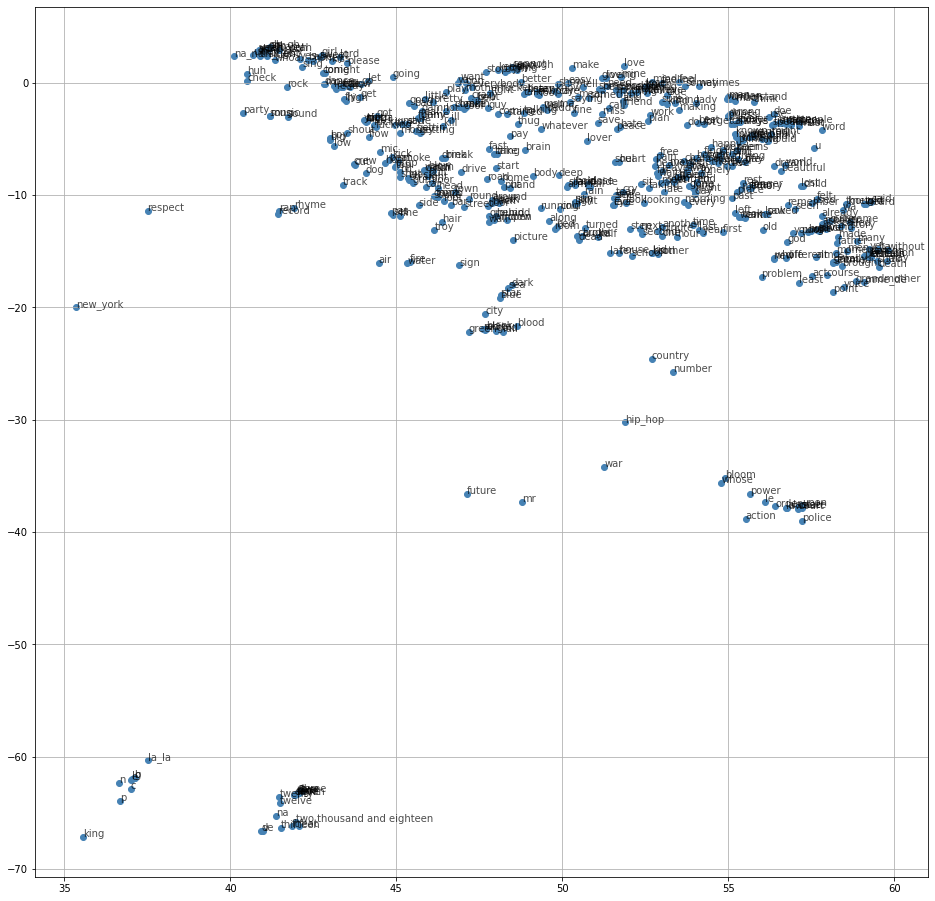

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(init='random')
embed_tsne = tsne.fit_transform(wv.vectors)

# We plot only 500 embeddings
fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
      
plt.grid()

In [28]:
del embed_tsne #clean memory
gc.collect()

35

So, what is left is to create a function that can link the keyed Vectors to the list of tokens representing the songs lyrics, and results in the embeeding vector of the lyrics of each song made by the vectors of the words that conform that song.

In [29]:
import numpy as np
def get_lyrics_vector(model, lyrics):
  vectors = []
  for token in lyrics:
      if token in model:
          vectors.append(model[token])
  if len(vectors) == 0:
      # If all tokens are OOV, return a vector of zeros
      return np.zeros(model.vector_size)
  else:
      return np.mean(vectors, axis=0)

lyrics_embeddings = []
for i in corpus:
    lyrics_embeddings.append(get_lyrics_vector(wv, i))


In [30]:
print(lyrics_embeddings[0])
print(len(lyrics_embeddings[0])) #we can see each of them has 200 dimensions
print(len(lyrics_embeddings)) #equals the number of songs

[-0.36856046 -0.09498765 -0.10148801  0.03039386  0.5273306   0.20222585
 -0.17890315 -0.17894001  0.02759714  0.37855858 -0.47005022  0.4204241
  0.08214556  0.15932256  0.24015127  0.06852086  0.13005908 -0.44472054
 -0.23482822  0.21849672 -0.19333172  0.32406595  0.07320573 -0.08845378
  0.05134746 -0.09155276  0.45911032 -0.4862409   0.74487704  0.16519472
 -0.10503864 -0.29868808  0.17877434  0.09369582 -0.24560837 -0.25186622
  0.32969764  0.35094357  0.15072729  0.22321598 -0.3955136  -0.28212628
 -0.02141023 -0.06860986 -0.22793578  0.07740035 -0.09793727  0.10850005
  0.28894877  0.41575062  0.0672313  -0.19129929 -0.14815886 -0.24263225
  0.07112227  0.08229981  0.02835251  0.11100583 -0.28307787  0.07597194
 -0.0321149   0.08435481  0.4215339  -0.1995688   0.30119416 -0.2409108
 -0.210104   -0.17432968  0.26905155  0.72722465 -0.15972567  0.32595432
  0.24993974 -0.6701071  -0.123153    0.05873205  0.3258702   0.07367159
 -0.15492381 -0.5716362   0.35224012 -0.25521567  0.1

##### __CLASSIFICATION__

Now that we have the embeedings of the lyrics, created and based in a word2vec modeled with the own songs, we have a representation of the lyrics in numbers, so we will work with some machine learning classifiers and see how wll they can classify by genre in <b>section 2<b>

##### **1.2.1.2 Word2Vec with Pre-Trained Model**

From the gensim documentation we decided to use the pre-trained model: "word2vec-google-news-300", that has 300 dimensions, which should be fine and enough for our objective.


In [31]:
import gensim.downloader as api

pre_w2v = api.load("word2vec-google-news-300")

In [32]:
print(type(pre_w2v))


<class 'gensim.models.keyedvectors.KeyedVectors'>


We can see that now we have directly a keyedvectors object, with the mapping between keys and vectors.

So we can directly pass to link the tokens we have in each of our songs's lyrics with the corresponding vector of our new keyed vectors object:

In [33]:
def get_lyrics_vector(model, lyrics):
  vectors = []
  for token in lyrics:
      if token in model:
          vectors.append(model[token])
  if len(vectors) == 0:
      # If all tokens are OOV, return a vector of zeros
      return np.zeros(model.vector_size)
  else:
      return np.mean(vectors, axis=0)

lyrics_embeddings_pre = []
for i in corpus:
    lyrics_embeddings_pre.append(get_lyrics_vector(pre_w2v, i))

In [34]:
print(lyrics_embeddings_pre[0])
print(len(lyrics_embeddings_pre[0])) #we can see each of them has 300 dimensions
print(len(lyrics_embeddings_pre)) #equals the number of songs

[ 0.03764191  0.01680911  0.02917939  0.07250047 -0.06872599 -0.0527283
  0.04931778 -0.07780812  0.10342871  0.1155538  -0.06705698 -0.10832203
 -0.06433553  0.02791469 -0.08942156  0.07580641  0.06468143  0.09460323
  0.02160174 -0.08267625 -0.01490749  0.08382135  0.07986633 -0.04091013
  0.06311885 -0.0069638  -0.06185263 -0.01732039  0.05336882 -0.04841734
 -0.07339673  0.04897331 -0.05919791 -0.01851171 -0.02823274 -0.08294087
  0.0716463  -0.02210689  0.04641913  0.09102935  0.06469021 -0.0963939
  0.13705072 -0.07202254 -0.03410276 -0.03430087 -0.0905313   0.00619811
 -0.00997948  0.06349027 -0.07168807  0.08087606  0.00952997 -0.00062997
  0.04841442  0.00883186 -0.04402878 -0.09251373  0.05344151 -0.04804488
 -0.01371192  0.03545097 -0.05698254 -0.03032231  0.00857108 -0.05201145
 -0.05650203  0.07186534 -0.10086951  0.06021252  0.04317943  0.03024957
  0.07271444 -0.00274859 -0.15255405 -0.06716308  0.06744245  0.05934751
  0.04092354  0.10571897  0.01696628 -0.03543182  0.0

So we are ready again to pass to the classification task, and see the difference between the word2vec created by ourselves with the data we have, and a much bigger pre-trained model linked afterwards with our lyrics.

#### **1.2.2 FastText Representation**

FastText is another approach toward word representation for future classification tasks we are going to develop during this notebook. Furthermore, we had an idea due to our Neural Network Course which was to implement an MLP NN in the classification task.

Moreover, this algorithim is idoneal for short docs as songs lyrics are and in classes notebook we saw a Pipeline which returns the average of the embeddings of the words which will be really useful for the Neural Network and its linear layers.

In order to maximize the performance and make our algorithm as robust as possible we will directly load any pre-trained model and adjust it using our corpus. Therefore, first of all we need to load the model which can help us as much as possible.

In [393]:
import compress_fasttext

fastTextPre = compress_fasttext.models.CompressedFastTextKeyedVectors.load(
    'ft_cc.en.300_freqprune_100K_20K_pq_100.bin'
)

We decided to dowload a pre-trained model from Github (https://github.com/avidale/compress-fasttext/releases/tag/gensim-4-draft) which is based on cc.en.300.bin which was the model we used in class but updated up to Gensim >= 4.0.0  also trained over a Facebook Dataset.

Let's show how this model has been trained by showing some similar words to the first word of the 5th first song of our dataset, just to check that clearly it makes sense to use it. Furthermore, even if the word does not appear in our FastText Dictionary, it will construct an embedding anyway therefore is very useful as we said before in order to make it as robust as possible to non-appearing words.

In [25]:
for w in corpus[:5]:
    print(f'Word similar to {w[0]}:')
    print(str(fastTextPre.most_similar(w[0]))+'\n')

Word similar to lady:
[('woman', 0.7058992023242795), ('gentleman', 0.6620858776059471), ('girl', 0.6586058469783472), ('ladies', 0.6508614740853009), ('man', 0.5864333917215517), ('maid', 0.5358822322333194), ('gal', 0.5181655356649635), ('hostess', 0.5132772625084043), ('guy', 0.5079906678342049), ('husband', 0.4979106432241984)]

Word similar to hey:
[('yeah', 0.7789288401059054), ('Hey', 0.6943406755833088), ('yes', 0.6628033304769274), ('dunno', 0.6605168916282228), ('Anyway', 0.6503646563032917), ('thats', 0.6460367334322566), ('anyways', 0.6437630045067626), ('Yeah', 0.6402671861130218), ('yea', 0.6398807760628002), ('maybe', 0.638750632189878)]

Word similar to upon:
[('Upon', 0.5571007189608188), ('on', 0.5232045155852151), ('based', 0.4705611885703212), ('solely', 0.4348302498291361), ('the', 0.42164649077587435), ('placed', 0.42072702630631886), ('brought', 0.3952660894980005), ('reliance', 0.394296303722936), ('dependent', 0.3939951307776036), ('rests', 0.3935409751083754)]

It looks quite good, for example an onomatopoeia such as 'hey' is related to others like 'yeah'. The main problem I see from this relations is that some of them are just the same word but starting in capital letters. That is not a big problem and we always can create our own model based on our corpus and compare its efficiency with respect to this one which clearly seems to have been worked properly.

Final step is the creation of our dataset from our corpus through the obtention of word embeddings mean of every song and from this we will be able to develop any classification task in the Second Part of this notebook.

In [209]:
from compress_fasttext.feature_extraction import FastTextTransformer

fastTextvec = FastTextTransformer(model=fastTextPre).transform(corpus)

print(f'Corpus Matrix Dimension is: {fastTextvec.shape}')

Corpus Matrix Dimension is: (3731, 300)


Using FastTextTransformer we are able to obtain the embbedings of every song lyrics in our dataset. As we can see the number of songs clearly coincide with the number of total songs our dataset has and 300 columns represents the vector size our pre-trained model has. This is sufficient enough to develop our Machine Learning Task but we will save it here and we will continue with this in the Second Part.

### **1.3 Topic Modeling**

Final step regarding data extraction from song lyrics is topic modeling. Our goal of applying this is to identify patterns in the language used in a text corpus, and then grouping similar words and phrases together to create coherent and distinct topics. Some of the most commonly used topic modeling algorithms include Latent Dirichlet Allocation (LDA).

Once the topics have been identified, they can be used to better understand the content of the text corpus, and to gain insights into trends, patterns, and themes within the data. 

Main decission here is the selection of the number of topics. Sometimes it is each one choices but fortunately always exists some methods that could help such as ``Coherience Models`` or a further implementation like ``Hierarchical Dirichlet Processes (HDP)`` which is an extension of LDA but adressing the number of topics when they are not known.

#### **1.3.1 Latent Dirichlet Allocation (LDA)**

First task is selecting the number of topics but not in an arbitrary way, they must be a reason behind. First thing we need to take into acount is the number of genre our song has which is 4. Furthermore, songs tends to be distributed in several topics: Politics, money, love, family... All these kind of topics could be found in different songs. Therefore, using a Coherence model and using the number of topics as a multiple of 4 let's see if what priorily we think is fulfilled or not:

In [60]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

100%|██████████| 6/6 [08:17<00:00, 82.94s/it]


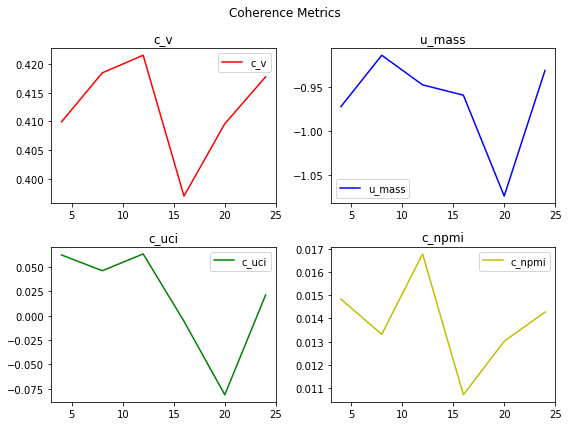

In [38]:
n_topics = [4*i for i in range(1,7)]
cv, umass, c_uci, c_npmi = [], [],[],[]
for ntpc in tqdm(n_topics):
    lda_ntpc = LdaModel(corpus=bow_songs, id2word=D, num_topics=ntpc)
    cv.append(CoherenceModel(lda_ntpc, texts=corpus, dictionary=D, coherence='c_v').get_coherence())
    umass.append(CoherenceModel(lda_ntpc, texts=corpus, dictionary=D, coherence='u_mass').get_coherence())
    c_uci.append(CoherenceModel(lda_ntpc, texts=corpus, dictionary=D, coherence='c_uci').get_coherence())
    c_npmi.append(CoherenceModel(lda_ntpc, texts=corpus, dictionary=D, coherence='c_npmi').get_coherence())


# Create a subplot:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

axes[0, 0].plot(n_topics,cv, 'r', label = 'c_v')
axes[0, 1].plot(n_topics,umass, 'b', label = 'u_mass')
axes[1, 0].plot(n_topics,c_uci, 'g', label = 'c_uci')
axes[1, 1].plot(n_topics,c_npmi, 'y', label = 'c_npmi')

# Add titles and legends
axes[0, 0].set_title('c_v')
axes[0, 1].set_title('u_mass')
axes[1, 0].set_title('c_uci')
axes[1, 1].set_title('c_npmi')

axes[0, 0].legend()
axes[0, 1].legend()
axes[1, 0].legend()
axes[1, 1].legend()


fig.suptitle('Coherence Metrics')
fig.tight_layout()
plt.show()


Despite it takes a lot of time to run, these plots will help us a lot because we will check different coefficients and we will keep the best for our model. As a very difficult task because there are words which could appear in many different lyrics such as musical onomatopeia which really could difficult this task as we will se later. 

From thsese plots, the main sugestion is selecting 16 topics. ``c_v``, ``c_npmi`` and ``u_mass`` sugest that: (On the report it will appear a deeper analysis)

In [61]:
topn = 25

ldag = LdaModel(corpus=bow_songs, id2word=D, num_topics=16)

100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


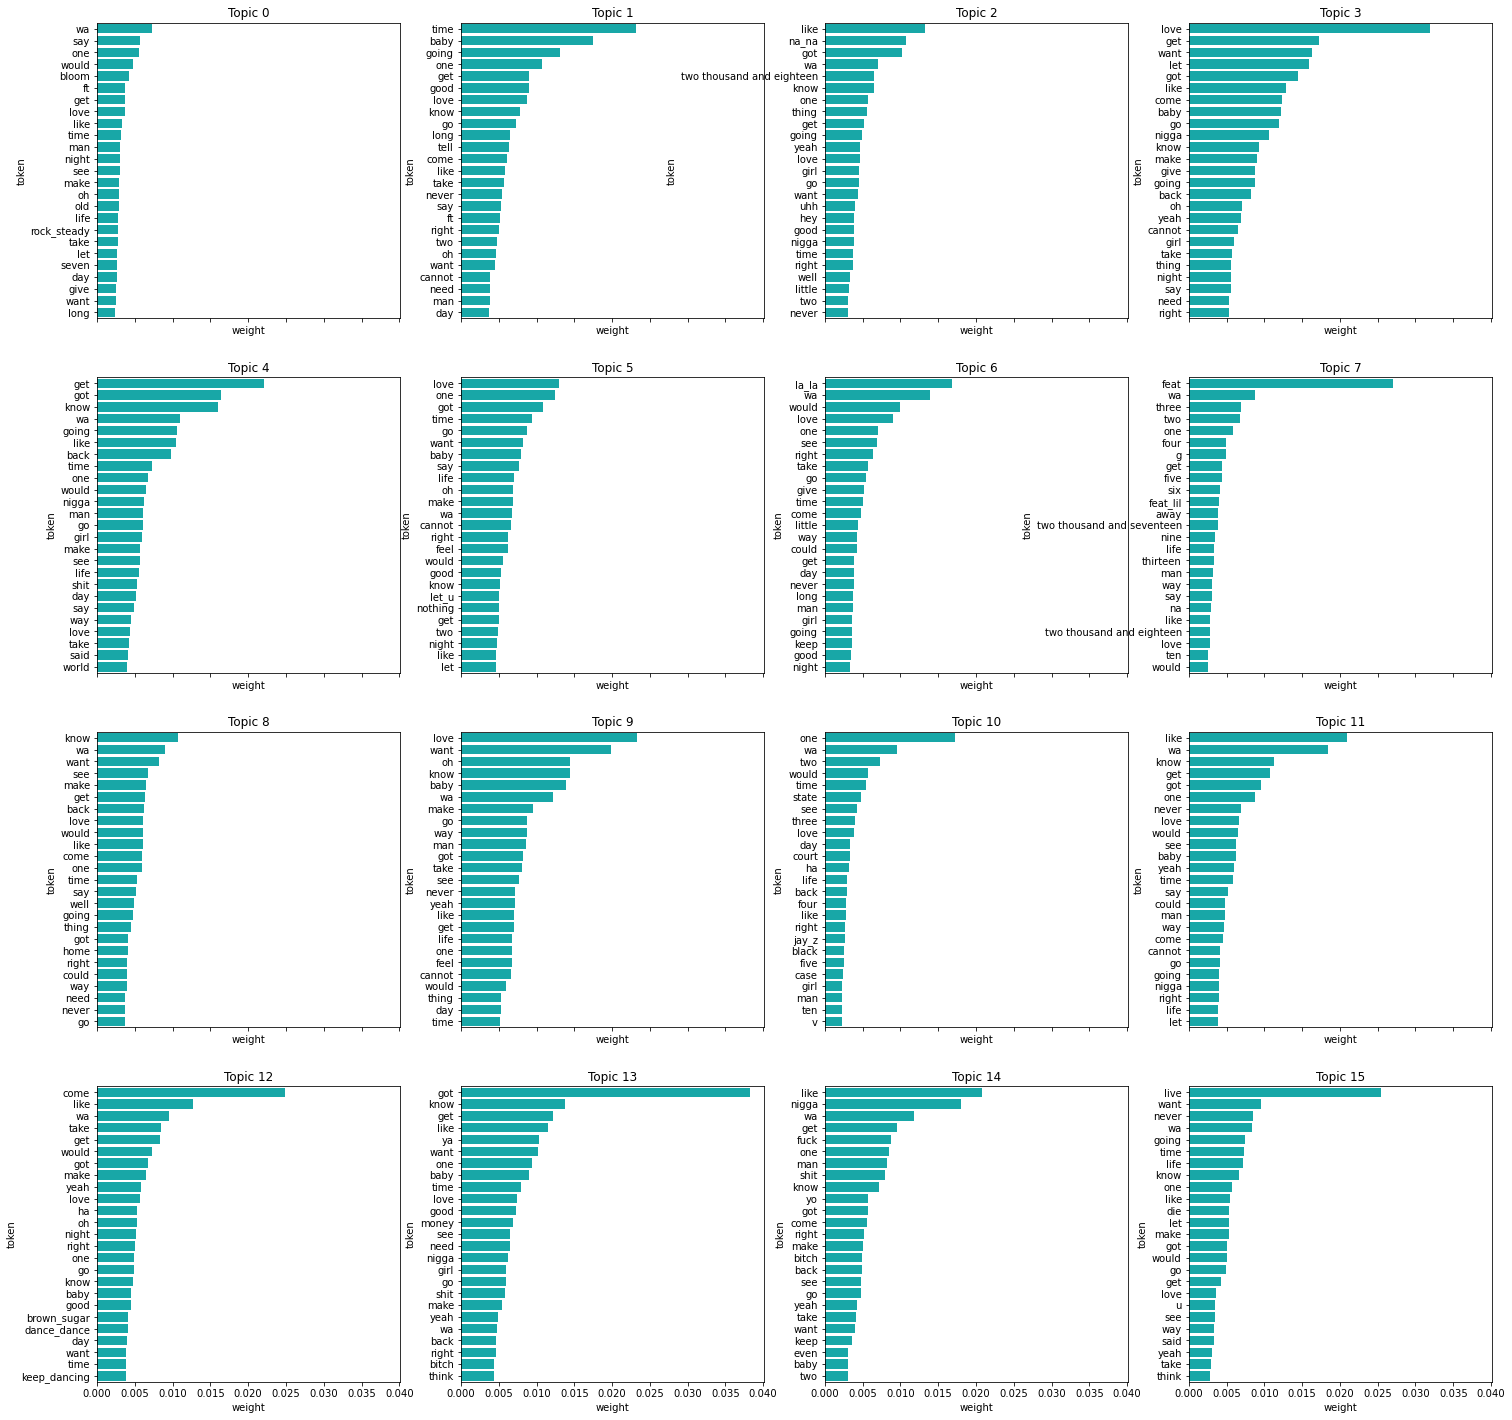

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(4, 4, figsize=(25, 25), sharex=True)

for i in tqdm(range(4)):

    df = pd.DataFrame(ldag.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))

    df = pd.DataFrame(ldag.show_topic(i+4, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+4))
    
    df = pd.DataFrame(ldag.show_topic(i+8, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[2][i])
    axes[2][i].set_title('Topic ' + str(i+8))
    
    df = pd.DataFrame(ldag.show_topic(i + 12, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[3][i])
    axes[3][i].set_title('Topic ' + str(i + 12))

plt.show()

In [62]:
from gensim.matutils import corpus2csc

ldaTrans = ldag[bow_songs]
ldaVec = corpus2csc(ldaTrans).transpose()

print(ldaVec.shape)

(3731, 16)


Very difficult to address these topics. Many words are repeated in several topics and from this is very difficult to extract some information __(Deeper analysis will be found in the report)__. 

Let's try to figure out another ways of generating models from topics. 

#### **1.3.2 Hierarchical Dirichlet Processes (HDP)**

As we said before, the idea of sharing statistical information between groups or clusters. HDP is a generative probabilistic model that allows for an infinite number of clusters or topics to be generated, making it suitable for tasks where the number of clusters or topics is not known in advance. It is idoneal for the task we want to address given the previous results from the LDA which was not sufficient enough.

We will repeat a similar experiment as we did before but know we will tune the parameter K which is the maximum number of topics for our model and as a measure we will keep the coherence among words:

In [73]:
from gensim.models import HdpModel

In [ ]:
K_list = [10,15,20,25,30]   
cv, umass, c_uci, c_npmi = [], [],[],[]
for k in tqdm(K_list):
    hdp =  HdpModel(corpus=bow_songs,  id2word=D,  K=k)
    cv.append(CoherenceModel(hdp, texts=corpus, dictionary=D, coherence='c_v').get_coherence())
    umass.append(CoherenceModel(hdp, texts=corpus, dictionary=D, coherence='u_mass').get_coherence())
    c_uci.append(CoherenceModel(hdp, texts=corpus, dictionary=D, coherence='c_uci').get_coherence())
    c_npmi.append(CoherenceModel(hdp, texts=corpus, dictionary=D, coherence='c_npmi').get_coherence())

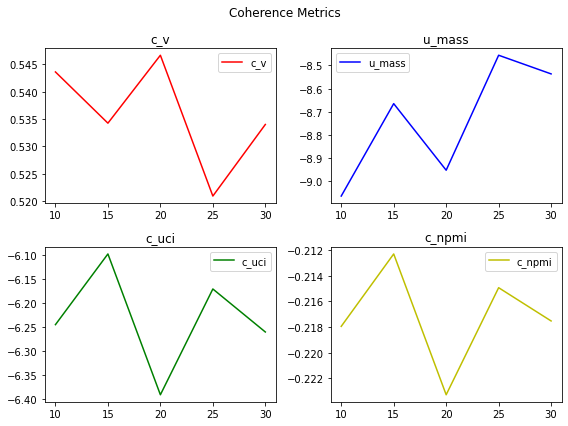

In [ ]:
# Create a subplot:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

axes[0, 0].plot(K_list,cv, 'r', label = 'c_v')
axes[0, 1].plot(K_list,umass, 'b', label = 'u_mass')
axes[1, 0].plot(K_list,c_uci, 'g', label = 'c_uci')
axes[1, 1].plot(K_list,c_npmi, 'y', label = 'c_npmi')

# Add titles and legends
axes[0, 0].set_title('c_v')
axes[0, 1].set_title('u_mass')
axes[1, 0].set_title('c_uci')
axes[1, 1].set_title('c_npmi')

axes[0, 0].legend()
axes[0, 1].legend()
axes[1, 0].legend()
axes[1, 1].legend()


fig.suptitle('Coherence Metrics')
fig.tight_layout()
plt.show()

From this plot clearly exits a tendency at K=20 for all the 4 models, so let's try to obtain a topic plot like we did before and hopefully it will make more sense, at least in coherence its value is greater:

In [74]:
topn = 25

hdp = HdpModel(corpus=bow_songs,  id2word=D,  K=20)

100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


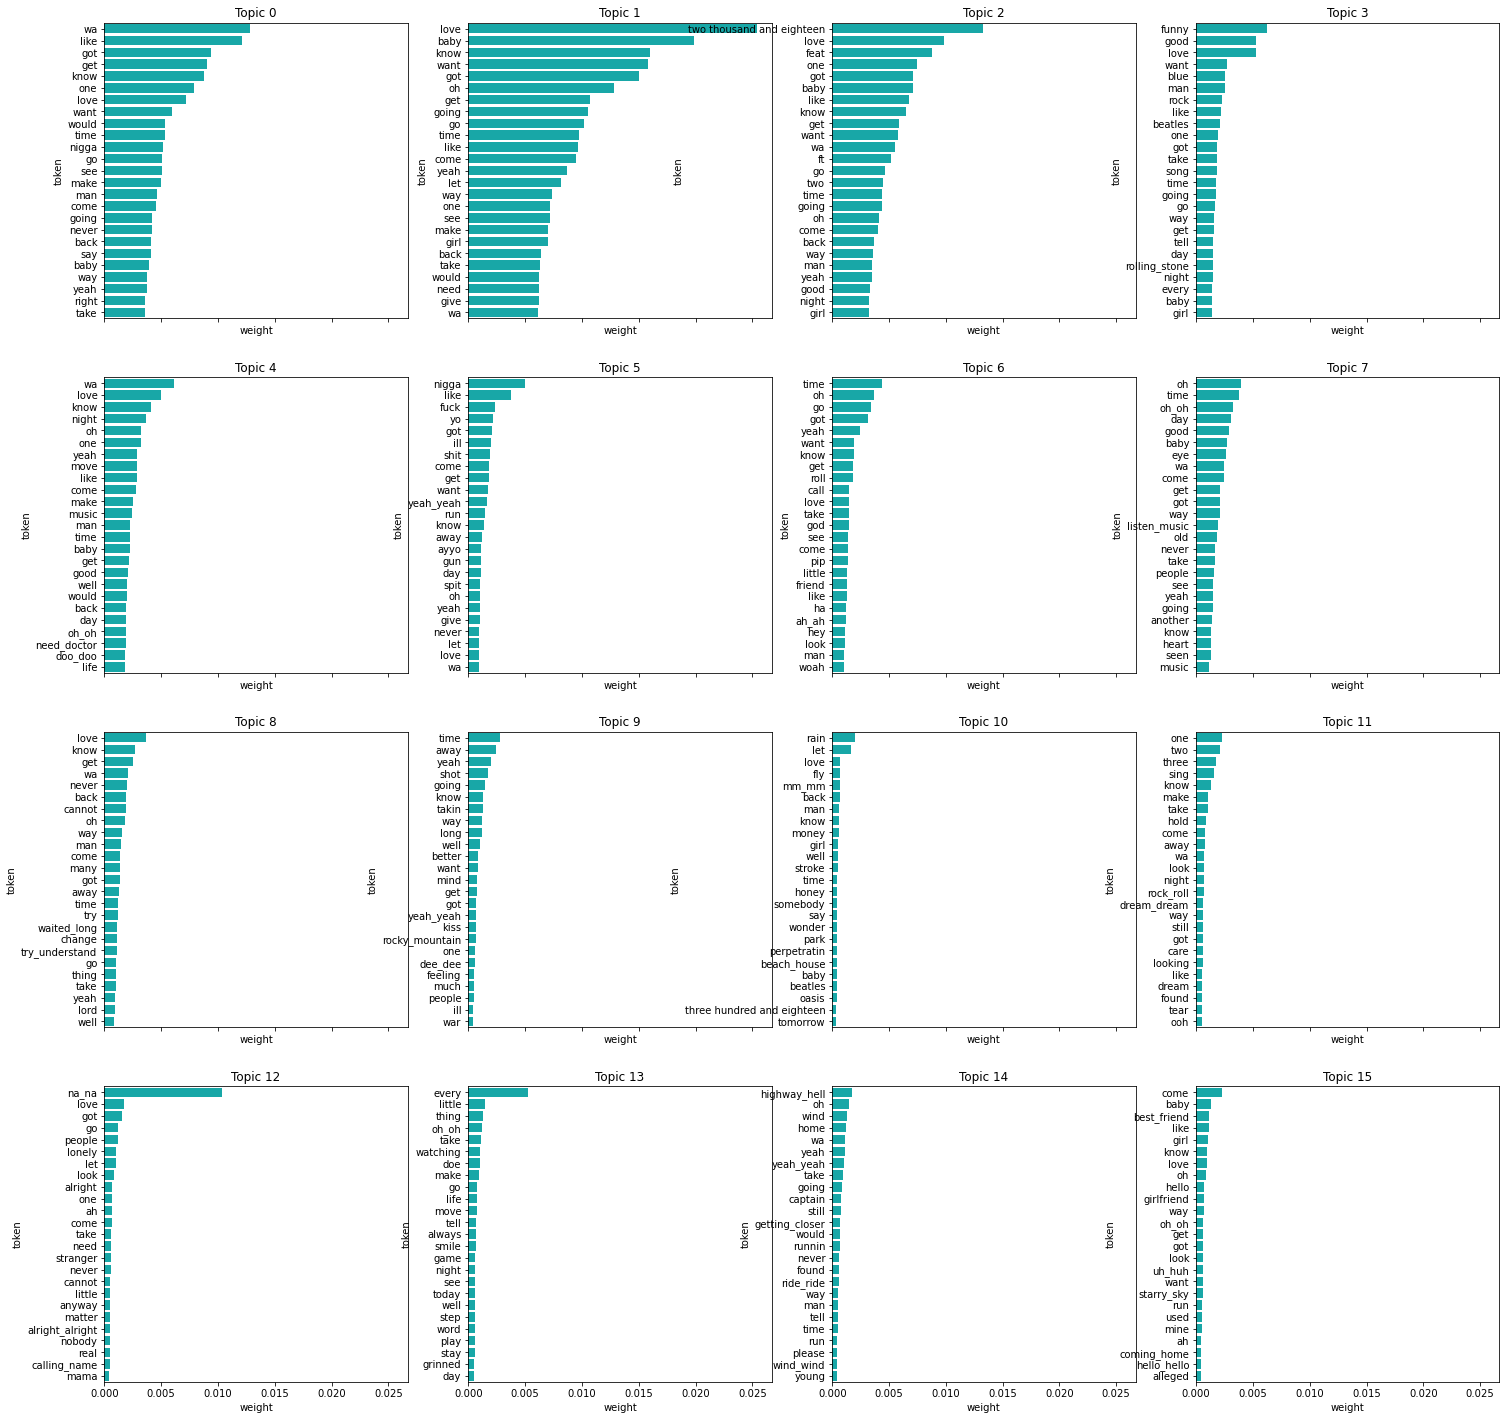

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(4, 4, figsize=(25, 25), sharex=True)

for i in tqdm(range(4)):

    df = pd.DataFrame(hdp.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))

    df = pd.DataFrame(hdp.show_topic(i+4, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+4))
    
    df = pd.DataFrame(hdp.show_topic(i+8, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[2][i])
    axes[2][i].set_title('Topic ' + str(i+8))
    
    df = pd.DataFrame(hdp.show_topic(i + 12, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[3][i])
    axes[3][i].set_title('Topic ' + str(i + 12))

plt.show()

Without many details, it seems to be better, words are less repeated during the topics and we can visualize some clear topics __(Report will be quite useful to compare it deeply)__ 

So, final step is the creation of a vectorized set to test in the second phase of this project, __classification__ one:

In [75]:
hdpTrans = hdp[bow_songs]
hdpVec = corpus2csc(hdpTrans).transpose()

print(hdpVec.shape)

(3731, 150)


I forgot to mention but the parameter which selects the number of total topics is T which is set by default (That is why we have 150 columns in our sparse) but I will keep it like that because the results are sufficient interesting enough and we already have hypertuned K value which is also regarding the number of topics per cluster, something also quite important in order to obtain best result  

## **2.Machine Learning Model**

### **2.1 Classification Task**

Eventhough the objective of the work is to work with different approaches of the NLP, a good way to see the utility of different methods (word2vec, tfidf, fasttext, lda, hdp...) is to compare their performance in tasks that require them. In this case, we want to create models capable to distinguish songs of 4 different genres. 

So we will develop different machine learning approaches to compare them, and recognize which of them are more useful for this task. In addition to the accuracy when predicting with X_test and Y_test, we will also include a ROC curve to have a visual explanation of how each different approach is behaiving with the different genres.

#### **2.1.1 Machine Learning Approach**

The main objective of this project, is to work with NLP and undertand the differences between different ways to represent our written words in numbers to later use them for classify, regression or recommender systems for example. 

This is the reason we have processed two different ways of word2vec and a fasttext, to study the differences. But the simpler way to prove it, in our case, is using them to predict by genre, that is classification.

As a first step, as the accuracies are not the most important part of the work, but still we want to get something that makes sense, we will just prove that our models can obtain models of machine learning that learn from the data to predict the genre, and it is not random.

In this way, as we have 4 genres, and the data is in general balanced, if the classifier works 'randomly' we could expect an accuracy of 0.25.
So, before applying classification to the 4 genres at the same time, we will check with dummies, that if we want to differentiate 1 genre of the other 3, that is a binary problem, we obtain more than 0.25 so we can discard a random behaviour, and we can justify that eventhough maybe the accuracies are not great, the model learns.

MODULES NEEDED FOR CLASSIFICATION TASK:

In [394]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

First we have to split the data and create an embeedings matrix:

In [36]:
random.seed(33)

Y = df['type'].values

# Discretize 'string' variables using sklearn
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

#1) SPlit the data
X_train, X_test, y_train, y_test = train_test_split(df['correctLyrics'], Y, test_size=0.3, random_state=33)

#2)Embeedings matrix
size_embeding = len(lyrics_embeddings[0])
X_train_emb = np.zeros((len(X_train), size_embeding))
for i, review in enumerate(X_train):
    X_train_emb[i] = get_lyrics_vector(wv, review)


And now we apply the dummy classifier with a embeeding matrix for the test as we have done with the train.

In [37]:
random.seed(33)
dummy = DummyClassifier(strategy="most_frequent") #we will try with the genre that appears most frequently
dummy.fit(X_train_emb, y_train)

# Evaluate the performance of the classifier on the test set
X_test_emb = np.zeros((len(X_test), size_embeding))
for i, review in enumerate(X_test):
    X_test_emb[i] = get_lyrics_vector(wv, review)

dummy_accuracy = dummy.score(X_test_emb, y_test)
dummy_accuracy_train = dummy.score(X_train_emb, y_train)


print(f"Dummy Classifying accuracy on the train set: {dummy_accuracy_train:.4f}")
print(f"Dummy Classifying accuracy on the test set: {dummy_accuracy:.4f}")


Dummy Classifying accuracy on the train set: 0.2585
Dummy Classifying accuracy on the test set: 0.2455


We can check with the dummy classifier, that, if we classify everything as the most frequent label of our objective class, in this case genres, the prediction accuracy drops to 1/4 that makes sense as the observations are pretty well balanced and we have 4 genres. So, with this information, we can later confirm that the models are learning something if they go above this accuracy, as the expected result of predicting randomly has to be around 0.25. If we later confirm this, and the accuracies are higher is enough to know that the models learn.

As we will repeat the same code several times to compare the classification between the different models we are going to use, let's create some functions for not repeating code and having a clean enviroment:

In [38]:
"""
WE WILL CREATE A GENERAL FUNCTION THAT CAN CREATE, RUN AND GIVE US A SCORE GIVEN
A MODEL AND IT'S PARAMETERS

AND ALSO A FUNCTION FOR CREATING THE X_TRAIN AND X_TEST EMBEEDINGS MATRIX

SOME EXPLANATION ABOUT THE PARAMETERS USED:
lyrics_model = the KEYED VECTOR of the word2vec, fasttext or any other model used
model = machine learning approach used for the classification: KNeighborsClassifier(), svc()...

"""

def embeeding_matrix(lyrics_model, X, lyrics_embeedings):
    random.seed(33)
    size_embeding = len(lyrics_embeedings[0])
    X_emb = np.zeros((len(X), size_embeding))
    for i, review in enumerate(X):
        X_emb[i] = get_lyrics_vector(lyrics_model, review)
    return X_emb


def classification_task(model, param_grid, x_tr_emb, x_tst_emb, y_train, y_test):
    random.seed(33)

    #1) Apply grid search to the model and param grid, and fit it
    grid_search = GridSearchCV(model, param_grid, cv = 5, refit=True)
    grid_search.fit(x_tr_emb, y_train)

    grid_search_best_estimator = grid_search.best_estimator_
    grid_search_accuracy = grid_search.score(x_tst_emb, y_test)
    grid_search_accuracy_train = grid_search.score(x_tr_emb, y_train) 
    grid_search_probs = grid_search.predict_proba(x_tst_emb)

    return {'accuracy':[grid_search_accuracy],'accuracy_train':[grid_search_accuracy_train],'best_estimator':[grid_search_best_estimator], 'probs':[grid_search_probs] }   


#### **2.1.1.1 Machine Learning Approach with TF-IDF**

Before working with the word2vec for classifying by genre, let's try with the TF-IDF. TF-IDF is a simpler approach as we know, so in theory it should result in worst accuracies, but as we can not know that, we do not lose anything checking the results in this way.

In [39]:
from gensim.matutils import corpus2csc
num_docs = D.num_docs
num_terms = len(D.keys())
corpus_tfidf_csc = corpus2csc(tfidf_songs, num_terms, num_docs=num_docs).T
print(corpus_tfidf_csc.shape)

(3731, 24464)


##### -KNN

In [40]:
Y = df['type'].values

# Discretize 'string' variables using sklearn
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(corpus_tfidf_csc  , Y, test_size=0.3, random_state=33)

random.seed(33)
model = KNeighborsClassifier()
param_grid = {'n_neighbors': [10,20,30,35,40,50,90, 100]}
grid_search = GridSearchCV(model, param_grid, cv = 5)

grid_search.fit(X_train_tfidf, y_train_tfidf)
acc_knn = grid_search.score(X_test_tfidf,y_test_tfidf)
grid_search_probs = grid_search.predict_proba(X_test_tfidf)
print("Test score KNN: " ,acc_knn)
print(grid_search.best_estimator_)
print("Train score KNN(to check overfitting): ", grid_search.score(X_train_tfidf,y_train_tfidf))

probs = np.array(grid_search_probs).squeeze()

Test score KNN:  0.6151785714285715
KNeighborsClassifier(n_neighbors=90)
Train score KNN(to check overfitting):  0.6472615855993872


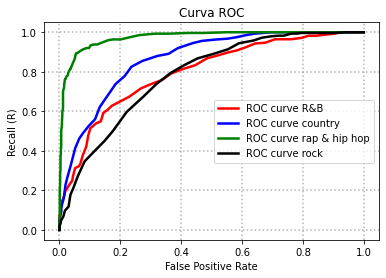

AUC ROC for KNN is 0.8538


In [41]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test_tfidf, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test_tfidf, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test_tfidf, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test_tfidf, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test_tfidf, probs,  multi_class='ovr')

print(f"AUC ROC for KNN is {area_roc:.4f}")

##### -SVM

In [43]:
random.seed(33)
model = SVC(probability=True)
param_grid = {'C': [1,5,9], 'kernel': ['rbf', 'linear']}
grid_search = GridSearchCV(model, param_grid, cv = 5)

grid_search.fit(X_train_tfidf, y_train_tfidf)
acc_svc = grid_search.score(X_test_tfidf,y_test_tfidf)
grid_search_probs = grid_search.predict_proba(X_test_tfidf)
print("Test score SVC: " ,acc_svc)
print(grid_search.best_estimator_)
print("Train score SVC(to check overfitting): ", grid_search.score(X_train_tfidf,y_train_tfidf))

probs = np.array(grid_search_probs).squeeze()

Test score SVC:  0.6625
SVC(C=1, kernel='linear', probability=True)
Train score SVC(to check overfitting):  0.9417847567981616


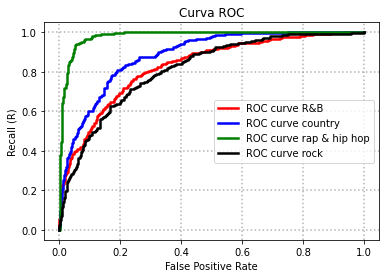

AUC ROC for SVM is 0.8775


In [44]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test_tfidf, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test_tfidf, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test_tfidf, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test_tfidf, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test_tfidf, probs,  multi_class='ovr')

print(f"AUC ROC for SVM is {area_roc:.4f}")

##### -Random Forest

In [45]:
random.seed(33)
model = RandomForestClassifier()
param_grid = {'n_estimators': [50,100,200,400], 'criterion':['gini', 'entropy'], 'max_depth':[2,5,10,15]}
grid_search = GridSearchCV(model, param_grid, cv = 5)

grid_search.fit(X_train_tfidf, y_train_tfidf)
acc_rf = grid_search.score(X_test_tfidf,y_test_tfidf)
grid_search_probs = grid_search.predict_proba(X_test_tfidf)
print("Test score RF: " ,acc_rf)
print(grid_search.best_estimator_)
print("Train score RF(to check overfitting): ", grid_search.score(X_train_tfidf,y_train_tfidf))

probs = np.array(grid_search_probs).squeeze()

Test score RF:  0.7008928571428571
RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=400)
Train score RF(to check overfitting):  0.9578705476828802


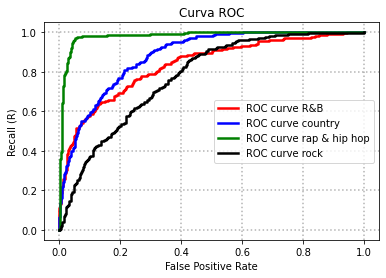

AUC ROC for RF is 0.8694


In [46]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test_tfidf, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test_tfidf, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test_tfidf, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test_tfidf, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test_tfidf, probs,  multi_class='ovr')

print(f"AUC ROC for RF is {area_roc:.4f}")

##### -Multinomial Logistic Regression

In [47]:
random.seed(33)
model = LogisticRegression()
param_grid = {'multi_class':['multinomial', 'ovr'], 'solver':['lbfgs'], 'C':[0.0001, 0.001, 0.01, 0.1, 0.5,1]}
grid_search = GridSearchCV(model, param_grid, cv = 5)

grid_search.fit(X_train_tfidf, y_train_tfidf)
acc_lr = grid_search.score(X_test_tfidf,y_test_tfidf)
grid_search_probs = grid_search.predict_proba(X_test_tfidf)
print("Test score LR: " ,acc_lr)
print(grid_search.best_estimator_)
print("Train score LR(to check overfitting): ", grid_search.score(X_train_tfidf,y_train_tfidf))
probs = np.array(grid_search_probs).squeeze()

Test score LR:  0.6616071428571428
LogisticRegression(C=1, multi_class='ovr')
Train score LR(to check overfitting):  0.9054002297970126


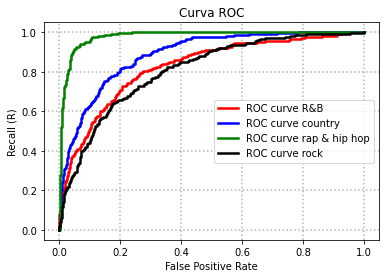

AUC ROC for LR is 0.8765


In [48]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test_tfidf, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test_tfidf, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test_tfidf, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test_tfidf, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test_tfidf, probs,  multi_class='ovr')

print(f"AUC ROC for LR is {area_roc:.4f}")

The result is not bad!!, but the bad thing about TF-IDF is that we have a matrix with rows equal to the number of sogns and columns equal to the number of words in the dictionary, so a lot of spaces are unused and a lot of the matrix is unnnecessary, so let's try using a PCA implementation on the TF-IDF matrix that keeps the most important info and as much variability as possible, and re-classify with it:

In [ ]:
"""
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline #LETS USE A PIPELINE TO JOIN PCA AND KNN IN ONE STEP
from gensim.matutils import corpus2dense #we need dense matrix for pca
num_docs = D.num_docs
num_terms = len(D.keys())
corpus_tfidf_dense = corpus2dense(tfidf_songs, num_terms, num_docs=num_docs).T
print(corpus_tfidf_dense.shape)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(corpus_tfidf_dense  , df['type'], test_size=0.3, random_state=33)

# Instantiate the pipeline object
# with PCA and kNN
pipe = Pipeline([('PCA', PCA()),
                ('kNN', KNeighborsClassifier())])
param_grid = {'kNN__n_neighbors': [10,20,30,35,40,50,90, 100]}
grid_search = GridSearchCV(pipe, param_grid, cv = 5)
# Fit the model object (with the scaled data)
grid_search.fit(X_train_tfidf, y_train_tfidf)

# Compute the score of the model object
acc_pca = grid_search.score(X_test_tfidf, y_test_tfidf)
"""

In general the results of classifying with TF-IDF are much better than what we expected. The reason may be the fact that for classifying by genre, the number of words by song and the amount of each of them, has the majority of the weight in this task, and the lack of information about the context of each of them inside the song can be compensated as some genres have a lot of different expressions that can differentiate them without having the information of the order of the words inside the song.

#### **2.1.1.2 Machine Learning Approach with self-created word2vec**

Let's create the embeedings matrix for the X_train and X_test:

In [49]:
random.seed(33)
X_train_emb = embeeding_matrix(wv, X_train, lyrics_embeedings=lyrics_embeddings)
X_test_emb = embeeding_matrix(wv, X_test, lyrics_embeedings=lyrics_embeddings)

##### -SVM

In [50]:
#Train with different hyper parameters the classifier and obtain the best result
random.seed(33)
svm = SVC(probability=True)
param_grid = {'C': [1,3,5,7,9], 'kernel': ['rbf', 'linear']}


result_svm = classification_task(svm, param_grid=param_grid, x_tr_emb = X_train_emb, x_tst_emb =X_test_emb, y_train = y_train, y_test = y_test)

print("SVM accuracy on the train set: ", result_svm['accuracy_train'])
print("SVM accuracy on the test set: ", result_svm['accuracy'])
print("Best SVM parameters are: ", result_svm['best_estimator'])
probs = np.array(result_svm['probs']).squeeze()

SVM accuracy on the train set:  [0.4569130601302183]
SVM accuracy on the test set:  [0.425]
Best SVM parameters are:  [SVC(C=9, kernel='linear', probability=True)]


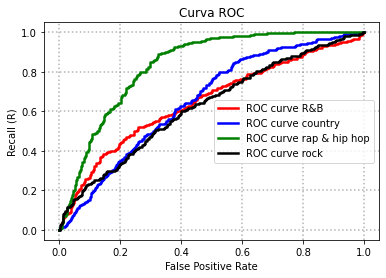

AUC ROC for SVM is 0.6922


In [51]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for SVM is {area_roc:.4f}")

##### -KNN

In [52]:
random.seed(33)
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [1,5,10,15,20,25,30,35,40]}

result_knn = classification_task(knn, param_grid=param_grid, x_tr_emb = X_train_emb, x_tst_emb =X_test_emb, y_train = y_train, y_test = y_test)

print("KNN accuracy on the train set: ", result_knn['accuracy_train'])
print("KNN accuracy on the test set: ", result_knn['accuracy'])
print("Best KNN parameters are: ", result_knn['best_estimator'])

probs = np.array(result_knn['probs']).squeeze()

KNN accuracy on the train set:  [0.5162772883952509]
KNN accuracy on the test set:  [0.41785714285714287]
Best KNN parameters are:  [KNeighborsClassifier(n_neighbors=15)]


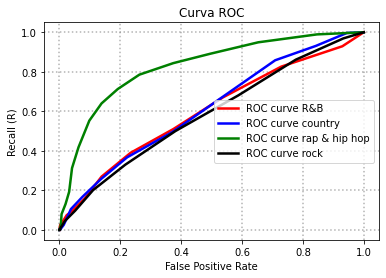

AUC ROC for KNN is 0.6551


In [53]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for KNN is {area_roc:.4f}")

##### -Random Forest

In [54]:
random.seed(33)
RF = RandomForestClassifier()
param_grid = {'n_estimators': [50,100,200,400], 'criterion':['gini', 'entropy'], 'max_depth':[2,5,10,15]}

result_rf = classification_task(RF, param_grid=param_grid, x_tr_emb = X_train_emb, x_tst_emb =X_test_emb, y_train = y_train, y_test = y_test)

print("RF accuracy on the train set: ", result_rf['accuracy_train'])
print("RF accuracy on the test set: ", result_rf['accuracy'])
print("Best RF parameters are: ", result_rf['best_estimator'])
probs = np.array(result_rf['probs']).squeeze()

RF accuracy on the train set:  [0.9341248563768672]
RF accuracy on the test set:  [0.44285714285714284]
Best RF parameters are:  [RandomForestClassifier(max_depth=10, n_estimators=200)]


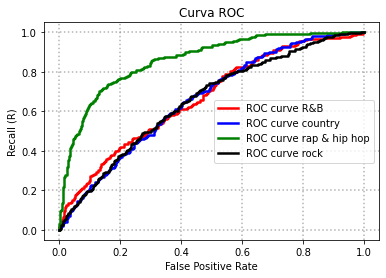

AUC ROC for RF is 0.7120


In [55]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for RF is {area_roc:.4f}")

##### -Multinomial Logistic Regression

In [56]:
random.seed(33)
lr = LogisticRegression()
param_grid = {'multi_class':['multinomial', 'ovr'], 'solver':['lbfgs'], 'C':[0.0001, 0.001, 0.01, 0.1, 0.5,1]}

result_lr = classification_task(lr, param_grid=param_grid, x_tr_emb = X_train_emb, x_tst_emb =X_test_emb, y_train = y_train, y_test = y_test)

print("LR accuracy on the train set: ", result_lr['accuracy_train'])
print("LR accuracy on the test set: ", result_lr['accuracy'])
print("Best LR parameters are: ", result_lr['best_estimator'])
probs = np.array(result_lr['probs']).squeeze()

c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

LR accuracy on the train set:  [0.4385292991191114]
LR accuracy on the test set:  [0.40714285714285714]
Best LR parameters are:  [LogisticRegression(C=1, multi_class='multinomial')]


c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


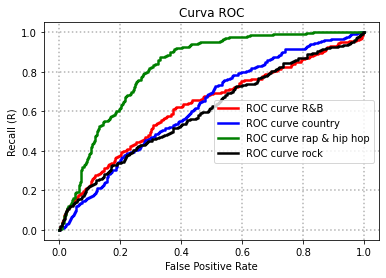

AUC ROC for LR is 0.6692


In [57]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for LR is {area_roc:.4f}")

#### **2.1.1.3 Machine Learning Approach with pre-trained word2vec**

We will follow exactly the same steps we have done with our word2vec, so we can compare the results in terms of accuracy of the classification.

In [58]:
random.seed(33)

#)Embeedings matrix USING THE PRE-TRAINED WORD2VEC MODEL
X_train_emb_pre = embeeding_matrix(pre_w2v, X_train, lyrics_embeedings=lyrics_embeddings_pre)
X_test_emb_pre = embeeding_matrix(pre_w2v, X_test, lyrics_embeedings=lyrics_embeddings_pre)


##### - SVM

In [59]:
#3)Train with different hyper parameters the classifier and obtain the best result
random.seed(33)
svm = SVC(probability=True)
param_grid = {'C': [1,3,5,7,9], 'kernel': ['rbf', 'linear']}

result_svm_pre = classification_task(svm, param_grid=param_grid, x_tr_emb = X_train_emb_pre, x_tst_emb =X_test_emb_pre, y_train = y_train, y_test = y_test)

print("SVM accuracy on the train set: ", result_svm_pre['accuracy_train'])
print("SVM accuracy on the test set: ", result_svm_pre['accuracy'])
print("Best SVM parameters are: ", result_svm_pre['best_estimator'])
probs = np.array(result_svm_pre['probs']).squeeze()

SVM accuracy on the train set:  [0.5457679050172348]
SVM accuracy on the test set:  [0.5232142857142857]
Best SVM parameters are:  [SVC(C=9, probability=True)]


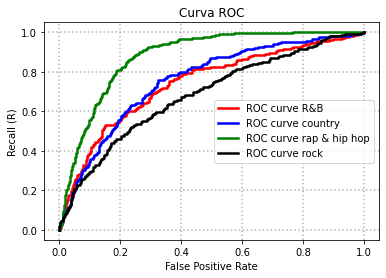

AUC ROC for SVM is 0.7661


In [60]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for SVM is {area_roc:.4f}")

##### -KNN

In [61]:
random.seed(33)
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [1,5,10,15,20,25,30,35,40]}

result_knn_pre = classification_task(knn, param_grid=param_grid, x_tr_emb = X_train_emb_pre, x_tst_emb =X_test_emb_pre, y_train = y_train, y_test = y_test)

print("KNN accuracy on the train set: ", result_knn_pre['accuracy_train'])
print("KNN accuracy on the test set: ", result_knn_pre['accuracy'])
print("Best KNN parameters are: ", result_knn_pre['best_estimator'])
probs = np.array(result_knn_pre['probs']).squeeze()

KNN accuracy on the train set:  [0.5250861738797395]
KNN accuracy on the test set:  [0.48660714285714285]
Best KNN parameters are:  [KNeighborsClassifier(n_neighbors=15)]


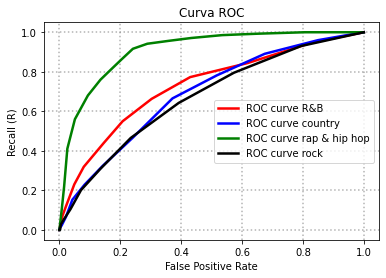

AUC ROC for KNN is 0.7475


In [62]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for KNN is {area_roc:.4f}")

##### -Random Forest

In [63]:
random.seed(33)
RF = RandomForestClassifier()
param_grid = {'n_estimators': [50,100,200,400], 'criterion':['gini', 'entropy'], 'max_depth':[2,5,10,12]}

result_rf_pre = classification_task(RF, param_grid=param_grid, x_tr_emb = X_train_emb_pre, x_tst_emb =X_test_emb_pre, y_train = y_train, y_test = y_test)

print("RF accuracy on the train set: ", result_rf_pre['accuracy_train'])
print("RF accuracy on the test set: ", result_rf_pre['accuracy'])
print("Best RF parameters are: ", result_rf_pre['best_estimator'])
probs = np.array(result_rf_pre['probs']).squeeze()

RF accuracy on the train set:  [0.9850631941784757]
RF accuracy on the test set:  [0.54375]
Best RF parameters are:  [RandomForestClassifier(max_depth=12, n_estimators=400)]


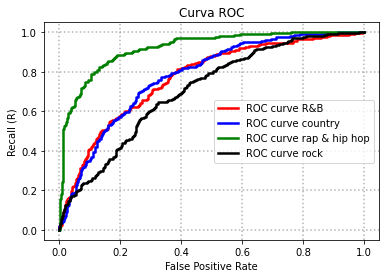

AUC ROC for RF is 0.7952


In [64]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for RF is {area_roc:.4f}")

##### -Multinomial Logistic Regression

In [65]:
random.seed(33)
lr = LogisticRegression()
param_grid = {'multi_class':['multinomial', 'ovr'], 'solver':['lbfgs'], 'C':[0.0001, 0.001, 0.01, 0.1, 0.5,1]}

result_lr_pre = classification_task(lr, param_grid=param_grid, x_tr_emb = X_train_emb_pre, x_tst_emb =X_test_emb_pre, y_train = y_train, y_test = y_test)

print("LR accuracy on the train set: ", result_lr_pre['accuracy_train'])
print("LR accuracy on the test set: ", result_lr_pre['accuracy'])
print("Best LR parameters are: ", result_lr_pre['best_estimator'])
probs = np.array(result_lr_pre['probs']).squeeze()

c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

LR accuracy on the train set:  [0.5243201838376101]
LR accuracy on the test set:  [0.4973214285714286]
Best LR parameters are:  [LogisticRegression(C=1, multi_class='multinomial')]


c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


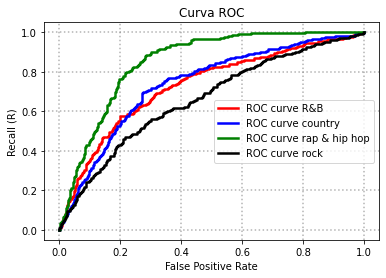

AUC ROC for LR is 0.7459


In [66]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for LR is {area_roc:.4f}")

We can see the results are better with the pre-trained model, what is in fact, what we expected, as word2vec works better with more words, and our self created model based on the lyrics of the song was not speccially big.

#### **2.1.1.4 Machine Learning Approach with pre-trained fastText**

In [28]:
Y = df['type'].values

# Discretize 'string' variables using sklearn
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

x_train, x_test, y_train, y_test = train_test_split(fastTextvec, Y, test_size=0.3, random_state=33)

##### - SVM

In [31]:
#Train with different hyper parameters the classifier and obtain the best result
random.seed(33)
svm = SVC(probability=True)
param_grid = {'C': [1,3,5,7,9], 'kernel': ['rbf', 'linear']}

result_svm_pre = classification_task(svm, param_grid=param_grid, x_tr_emb = x_train, x_tst_emb =x_test, y_train = y_train, y_test = y_test)

print("SVM accuracy on the train set: ", result_svm_pre['accuracy_train'])
print("SVM accuracy on the test set: ", result_svm_pre['accuracy'])
print("Best SVM parameters are: ", result_svm_pre['best_estimator'])
probs = np.array(result_svm_pre['probs']).squeeze()

SVM accuracy on the train set:  [0.9134431252393719]
SVM accuracy on the test set:  [0.5633928571428571]
Best SVM parameters are:  [SVC(C=3, probability=True)]


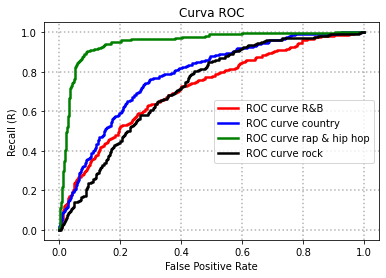

AUC ROC for SVM is 0.7932


In [47]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for SVM is {area_roc:.4f}")

##### - KNN

In [54]:
random.seed(33)
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [1,5,10,15,20,25,30,35,40]}

result_knn_pre = classification_task(knn, param_grid=param_grid, x_tr_emb = x_train, x_tst_emb =x_test, y_train = y_train, y_test = y_test)

print("KNN accuracy on the train set: ", result_knn_pre['accuracy_train'])
print("KNN accuracy on the test set: ", result_knn_pre['accuracy'])
print("Best KNN parameters are: ", result_knn_pre['best_estimator'])
probs = np.array(result_knn_pre['probs']).squeeze()

KNN accuracy on the train set:  [0.26579854461891994]
KNN accuracy on the test set:  [0.26160714285714287]
Best KNN parameters are:  [KNeighborsClassifier(n_neighbors=30)]


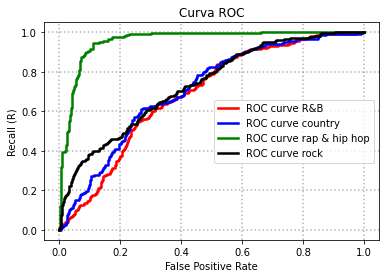

AUC ROC for KNN is 0.7741


In [85]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for KNN is {area_roc:.4f}")

##### - Random Forest

In [56]:
random.seed(33)
RF = RandomForestClassifier()
param_grid = {'n_estimators': [50,100,200,400], 'criterion':['gini', 'entropy'], 'max_depth':[2,5,10,12]}

result_rf_pre = classification_task(RF, param_grid=param_grid, x_tr_emb = x_train, x_tst_emb =x_test, y_train = y_train, y_test = y_test)

print("RF accuracy on the train set: ", result_rf_pre['accuracy_train'])
print("RF accuracy on the test set: ", result_rf_pre['accuracy'])
print("Best RF parameters are: ", result_rf_pre['best_estimator'])
probs = np.array(result_rf_pre['probs']).squeeze()

RF accuracy on the train set:  [0.9670624281884336]
RF accuracy on the test set:  [0.5214285714285715]
Best RF parameters are:  [RandomForestClassifier(max_depth=10, n_estimators=400)]


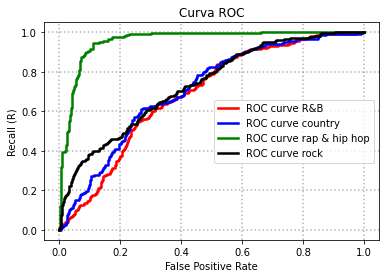

AUC ROC for RF is 0.7741


In [86]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for RF is {area_roc:.4f}")

##### - Multinomial Logistic Regression

In [58]:
random.seed(33)
lr = LogisticRegression()
param_grid = {'multi_class':['multinomial', 'ovr'], 'solver':['lbfgs'], 'C':[0.0001, 0.001, 0.01, 0.1, 0.5,1]}

result_lr_pre = classification_task(lr, param_grid=param_grid, x_tr_emb = x_train, x_tst_emb =x_test, y_train = y_train, y_test = y_test)

print("LR accuracy on the train set: ", result_lr_pre['accuracy_train'])
print("LR accuracy on the test set: ", result_lr_pre['accuracy'])
print("Best LR parameters are: ", result_lr_pre['best_estimator'])
probs = np.array(result_lr_pre['probs']).squeeze()

LR accuracy on the train set:  [0.6514745308310992]
LR accuracy on the test set:  [0.5589285714285714]
Best LR parameters are:  [LogisticRegression(C=1, multi_class='multinomial')]


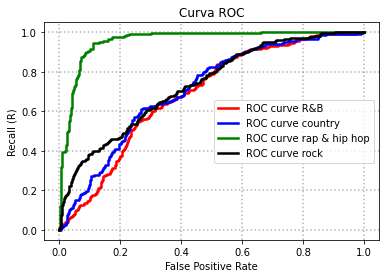

AUC ROC for LR is 0.7741


In [87]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for LR is {area_roc:.4f}")

Overall, really similar to word2vec but we would say that it performance is slighly better but not suffient enough to defeat the model obtained from the TFIDF but without overfitting this time.

Regarding the models, RF took a lot to execute and it result was not promising, KNN did not perform clearly and SVM is quite powerful using fastText vectorization.

#### **2.1.1.5 Machine Learning Approach with Topic Modeling Models - LDA**

In [63]:
Y = df['type'].values

# Discretize 'string' variables using sklearn
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

x_train, x_test, y_train, y_test = train_test_split(ldaVec, Y, test_size=0.3, random_state=33)

##### - SVM

In [64]:
random.seed(33)
svm = SVC(probability=True)
param_grid = {'C': [1,3,5,7,9], 'kernel': ['rbf', 'linear']}

result_svm_pre = classification_task(svm, param_grid=param_grid, x_tr_emb = x_train, x_tst_emb =x_test, y_train = y_train, y_test = y_test)

print("SVM accuracy on the train set: ", result_svm_pre['accuracy_train'])
print("SVM accuracy on the test set: ", result_svm_pre['accuracy'])
print("Best SVM parameters are: ", result_svm_pre['best_estimator'])
probs = np.array(result_svm_pre['probs']).squeeze()

SVM accuracy on the train set:  [0.5610877058598238]
SVM accuracy on the test set:  [0.48660714285714285]
Best SVM parameters are:  [SVC(C=5, probability=True)]


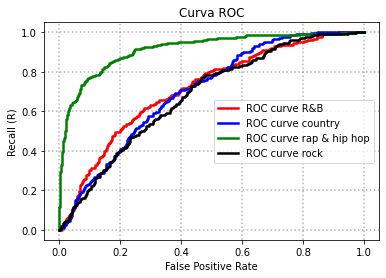

AUC ROC for SVM is 0.7546


In [66]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for SVM is {area_roc:.4f}")

##### - KNN

In [67]:
random.seed(33)
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [1,5,10,15,20,25,30,35,40]}

result_knn_pre = classification_task(knn, param_grid=param_grid, x_tr_emb = x_train, x_tst_emb =x_test, y_train = y_train, y_test = y_test)

print("KNN accuracy on the train set: ", result_knn_pre['accuracy_train'])
print("KNN accuracy on the test set: ", result_knn_pre['accuracy'])
print("Best KNN parameters are: ", result_knn_pre['best_estimator'])
probs = np.array(result_knn_pre['probs']).squeeze()

KNN accuracy on the train set:  [0.5166602834163155]
KNN accuracy on the test set:  [0.4642857142857143]
Best KNN parameters are:  [KNeighborsClassifier(n_neighbors=30)]


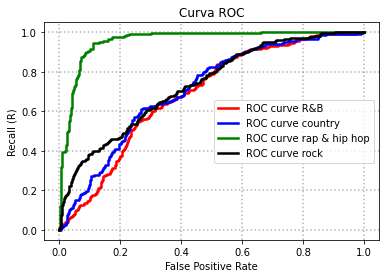

AUC ROC for KNN is 0.7741


In [88]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for KNN is {area_roc:.4f}")

##### - Random Forest

In [69]:
random.seed(33)
RF = RandomForestClassifier()
param_grid = {'n_estimators': [50,100,200,400], 'criterion':['gini', 'entropy'], 'max_depth':[2,5,10,12]}

result_rf_pre = classification_task(RF, param_grid=param_grid, x_tr_emb = x_train, x_tst_emb =x_test, y_train = y_train, y_test = y_test)

print("RF accuracy on the train set: ", result_rf_pre['accuracy_train'])
print("RF accuracy on the test set: ", result_rf_pre['accuracy'])
print("Best RF parameters are: ", result_rf_pre['best_estimator'])
probs = np.array(result_rf_pre['probs']).squeeze()

RF accuracy on the train set:  [0.7280735350440444]
RF accuracy on the test set:  [0.4928571428571429]
Best RF parameters are:  [RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200)]


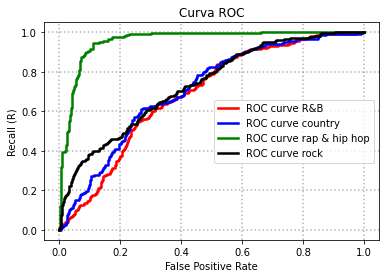

AUC ROC for RF is 0.7741


In [89]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for RF is {area_roc:.4f}")

##### - Multinomial Logistic Regression

In [71]:
random.seed(33)
lr = LogisticRegression()
param_grid = {'multi_class':['multinomial', 'ovr'], 'solver':['lbfgs'], 'C':[0.0001, 0.001, 0.01, 0.1, 0.5,1]}

result_lr_pre = classification_task(lr, param_grid=param_grid, x_tr_emb = x_train, x_tst_emb =x_test, y_train = y_train, y_test = y_test)

print("LR accuracy on the train set: ", result_lr_pre['accuracy_train'])
print("LR accuracy on the test set: ", result_lr_pre['accuracy'])
print("Best LR parameters are: ", result_lr_pre['best_estimator'])
probs = np.array(result_lr_pre['probs']).squeeze()

LR accuracy on the train set:  [0.4791267713519724]
LR accuracy on the test set:  [0.4642857142857143]
Best LR parameters are:  [LogisticRegression(C=0.5, multi_class='ovr')]


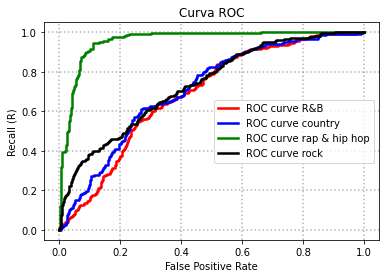

AUC ROC for LR is 0.7741


In [90]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for LR is {area_roc:.4f}")

LDA did not figure out, it does not reach a half of correctly classified songs and it is repeated for all the classification models therefore the problem may be on the LDA model not in our classifiers.

Let's see HDP, which we have high hopes and will be the last model we are going to use to classify.

#### **2.1.1.6 Machine Learning Approach with Topic Modeling Models - HDP**

In [76]:
Y = df['type'].values

# Discretize 'string' variables using sklearn
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

x_train, x_test, y_train, y_test = train_test_split(hdpVec, Y, test_size=0.3, random_state=33)

##### - SVM

In [77]:
random.seed(33)
svm = SVC(probability=True)
param_grid = {'C': [1,3,5,7,9], 'kernel': ['rbf', 'linear']}

result_svm_pre = classification_task(svm, param_grid=param_grid, x_tr_emb = x_train, x_tst_emb =x_test, y_train = y_train, y_test = y_test)

print("SVM accuracy on the train set: ", result_svm_pre['accuracy_train'])
print("SVM accuracy on the test set: ", result_svm_pre['accuracy'])
print("Best SVM parameters are: ", result_svm_pre['best_estimator'])
probs = np.array(result_svm_pre['probs']).squeeze()

SVM accuracy on the train set:  [0.5281501340482574]
SVM accuracy on the test set:  [0.5035714285714286]
Best SVM parameters are:  [SVC(C=1, probability=True)]


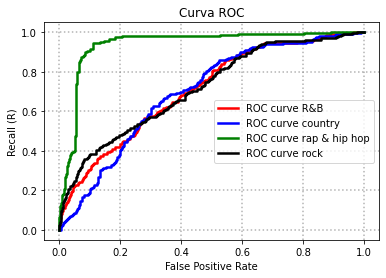

AUC ROC for SVM is 0.7678


In [78]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for SVM is {area_roc:.4f}")

##### - KNN

In [79]:
random.seed(33)
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [1,5,10,15,20,25,30,35,40]}

result_knn_pre = classification_task(knn, param_grid=param_grid, x_tr_emb = x_train, x_tst_emb =x_test, y_train = y_train, y_test = y_test)

print("KNN accuracy on the train set: ", result_knn_pre['accuracy_train'])
print("KNN accuracy on the test set: ", result_knn_pre['accuracy'])
print("Best KNN parameters are: ", result_knn_pre['best_estimator'])
probs = np.array(result_knn_pre['probs']).squeeze()

KNN accuracy on the train set:  [0.5450019149751053]
KNN accuracy on the test set:  [0.5035714285714286]
Best KNN parameters are:  [KNeighborsClassifier(n_neighbors=25)]


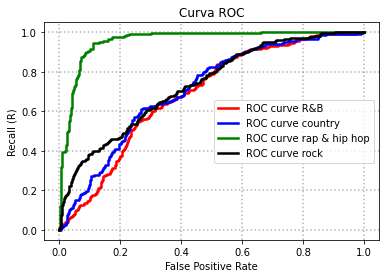

AUC ROC for KNN is 0.7741


In [91]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for KNN is {area_roc:.4f}")

##### - Random Forest

In [81]:
random.seed(33)
RF = RandomForestClassifier()
param_grid = {'n_estimators': [50,100,200,400], 'criterion':['gini', 'entropy'], 'max_depth':[2,5,10,12]}

result_rf_pre = classification_task(RF, param_grid=param_grid, x_tr_emb = x_train, x_tst_emb =x_test, y_train = y_train, y_test = y_test)

print("RF accuracy on the train set: ", result_rf_pre['accuracy_train'])
print("RF accuracy on the test set: ", result_rf_pre['accuracy'])
print("Best RF parameters are: ", result_rf_pre['best_estimator'])
probs = np.array(result_rf_pre['probs']).squeeze()

RF accuracy on the train set:  [0.5947912677135198]
RF accuracy on the test set:  [0.5330357142857143]
Best RF parameters are:  [RandomForestClassifier(max_depth=12, n_estimators=400)]


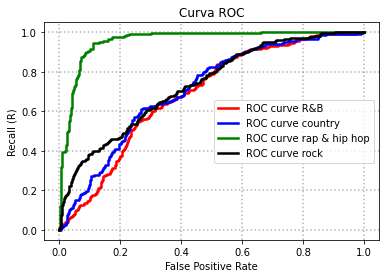

AUC ROC for RF is 0.7741


In [92]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for RF is {area_roc:.4f}")

##### - Multinomial Logistic Regression

In [94]:
random.seed(33)
lr = LogisticRegression()
param_grid = {'multi_class':['multinomial', 'ovr'], 'solver':['lbfgs'], 'C':[0.0001, 0.001, 0.01, 0.1, 0.5,1]}

result_lr_pre = classification_task(lr, param_grid=param_grid, x_tr_emb = x_train, x_tst_emb =x_test, y_train = y_train, y_test = y_test)

print("LR accuracy on the train set: ", result_lr_pre['accuracy_train'])
print("LR accuracy on the test set: ", result_lr_pre['accuracy'])
print("Best LR parameters are: ", result_lr_pre['best_estimator'])
probs = np.array(result_lr_pre['probs']).squeeze()

LR accuracy on the train set:  [0.5239371888165454]
LR accuracy on the test set:  [0.5330357142857143]
Best LR parameters are:  [LogisticRegression(C=1, multi_class='multinomial')]


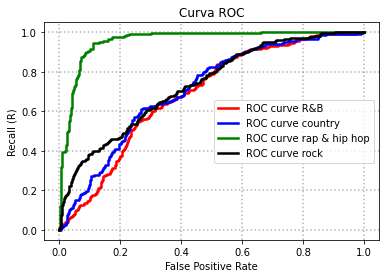

AUC ROC for LR is 0.7741


In [95]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for LR is {area_roc:.4f}")

Final vectorization model, maybe it is not the best in terms of accuracy but this HDP model overperforms LDA clearly and it is quite interesting to predict ``rap & hip hop`` genre because as we explained in the report, some topics we saw are really of these kind of songs and the model appreciate it.

#### **2.1.2 Deep Learning Approach**

##### **2.1.2.1 Multi-Layer Perceptron (MLP)**

During our course on Neural Networks(https://aplicaciones.uc3m.es/cpa/generaFicha?&est=350&plan=392&asig=16506&idioma=2) we have learned how to develop many types of NN such as MLPs, CNNs, RNNs etc. For this simple task of classification, directly comes to our mind a MLP which is one of the simplest ones and using the mean of the embbedings our text vectorization models has provided us we can direclty train this kind of NN and compare its result with respect to the previous obtained by different machine learning algorithms we have provided.

First of all is neccesary to load Pytorch which will be the Deep Learning library we have been using during the course:

In [205]:
import torch
from torch import nn
from torch import optim

Next step is the obtention of a training and testing set and because we are talking about Deep learning, in order to check overfitting during the training. 

We are going to use fastText representation because ignoring TFIDF which is very big dimensionally speaking and MLP will not figure out, fastText provide really interestings results overall and deserves a chance: 

In [283]:
Y = df['type'].values

# Discretize 'string' variables using sklearn
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

x_train, x_test, y_train, y_test = train_test_split(fastTextvec, Y, test_size=0.3, random_state=33)

#Validation set is obtained from the train set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=33)

In [284]:
class MLP_2layer(nn.Module):
    def __init__(self,input_size,hidden1,hidden2,output_size, drop): 
        super().__init__()
        
        self.output1 = nn.Linear(input_size,hidden1)
        self.output2 = nn.Linear(hidden1,hidden2)
        self.output3 = nn.Linear(hidden2,output_size)
        
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)     
        self.dropout = nn.Dropout(drop)                                                        
        
    def forward(self, x):
        # First Layer
        x = self.dropout(self.relu(self.output1(x)))
        # Second Layer
        x = self.dropout(self.relu(self.output2(x)))
        # Output 
        out = self.logsoftmax(self.output3(x))
        return out
    
class MLP_2layer_train(MLP_2layer):
    
    def __init__(self,input_size,hidden1,hidden2, output_size, drop=0.0,lr=0.0005, batch_size=50):
        
        super().__init__(input_size,hidden1,hidden2,output_size,drop)  
        
        self.lr = lr # Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer
        self.criterion = nn.NLLLoss()               
        
        self.batch_size = batch_size
        self.loss_during_training = [] 
        self.valid_loss_during_training = [] 
           
    def score(self,x_test,Y):
        accuracy = 0.0
        
        with torch.no_grad(): 
            logprobs = self.forward(torch.Tensor(x_test)).detach().numpy()
            if(len(Y)>0):
                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]
            
        return logprobs,accuracy
            
    def fit(self,x_train,x_val,Y,Yval,epochs=100):
        x_train = torch.Tensor(x_train)
        x_val = torch.Tensor(x_val)
        labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels
        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels
        
        self.epochs=epochs
        
        self.num_train = len(x_train) # Number of training points
        self.num_batchs = np.floor(self.num_train/self.batch_size) # Number of training batches
        self.num_val = len(x_val) # Number of validation points
        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numero of validating batches
        
        
        for e in tqdm(range(int(self.epochs))): 
            self.train() # Activate dropout
            running_loss = 0.
            
            # Random data permutation
            idx = np.random.permutation(self.num_train)
            
            for i in range(int(self.num_batchs)):
                self.optim.zero_grad() 
                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
                # We compute the classifier output for every data
                out = self.forward(x_train[idx_batch])
                # Cost function and gradient descent step
                loss = self.criterion(out,labels[idx_batch])
                running_loss += loss.item()
                loss.backward()
                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                # SGD steps
                self.optim.step()
            
            # print(running_loss)
            self.loss_during_training.append(running_loss/self.num_batchs)
            
            # We repeat for validation
            with torch.no_grad():    
                # set model to evaluation mode
                self.eval()
                running_loss = 0.
                
                idx = np.random.permutation(self.num_val)
                
                for i in range(int(self.num_batchs_val)):
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size] 
                    out = self.forward(x_val[idx_batch])
                    loss = self.criterion(out,labelsval[idx_batch])
                    running_loss += loss.item() 
                    
                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)    
                    

class MLP_3layer(nn.Module):
    def __init__(self,input_size,hidden1,hidden2,hidden3,output_size,p): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(input_size,hidden1)
        self.output2 = nn.Linear(hidden1,hidden2)
        self.output3 = nn.Linear(hidden2,hidden3)
        self.output4 = nn.Linear(hidden3,output_size)
        
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)     
        self.dropout = nn.Dropout(p)                                                        
        
    def forward(self, x):
        # First Layer
        x = self.dropout(self.relu(self.output1(x)))
        # Second Layer
        x = self.dropout(self.relu(self.output2(x)))
        # Third Layer
        x = self.dropout(self.relu(self.output3(x)))
        # Output 
        out = self.logsoftmax(self.output4(x))
        return out

The datails of above NN will be especially especified at the report but averall is a MLP with 2 linear layers and Negative Log-Likelihood as loss function in order to check overfitting over the validation set.

Now is the moment of defining the MLP, training it and plot how much the loss varies depending on which is the set:

In [285]:
my_MLP1 = MLP_2layer_train(input_size=300, hidden1 = 32, hidden2 = 16, 
                        output_size = 4, drop=0.33)


my_MLP1.fit(x_train,x_val,y_train,y_val,epochs=50)

100%|██████████| 50/50 [00:06<00:00,  8.16it/s]


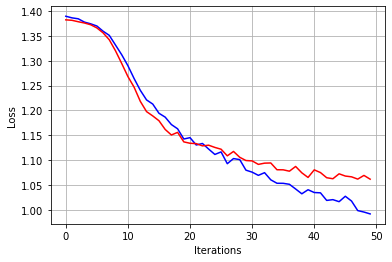

In [286]:
plt.plot(my_MLP1.loss_during_training,label='Training Cross Entropy Loss', color = 'blue')
plt.plot(my_MLP1.valid_loss_during_training,label='validation Cross Entropy Loss', color = 'red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

From above plot we can see that after 50-60 iterations our model became to overfit. Let's visualize the accuracy of the model:

In [287]:
logprobs,acc = my_MLP1.score(x_test, y_test)

probs = np.exp(logprobs)  

print(f"The test accuracy is {acc}")

[[-1.5874088  -0.7942007  -5.7832336  -1.0772688 ]
 [-2.2295585  -2.0893962  -0.4293675  -2.139263  ]
 [-1.3197817  -1.2204247  -3.6286561  -0.88879794]
 ...
 [-1.138106   -1.4155024  -1.9483033  -1.223307  ]
 [-2.841447   -2.6633027  -0.20979622 -2.7937424 ]
 [-1.9730643  -0.64744806 -4.8266387  -1.1099461 ]]
The test accuracy is 0.5151785714285714


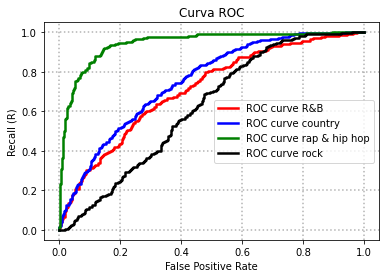

AUC ROC for MLP1 is 0.7585


In [215]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for MLP1 is {area_roc:.4f}")

That's not enough, our MLP with high droput did not figure out. From this base let's develop another MLP but now adding another layer and reducing the dropout during the process:

In [216]:
class MLP_3layer(nn.Module):
    def __init__(self,input_size,hidden1,hidden2,hidden3,output_size,p): 
        super().__init__()
        
        self.output1 = nn.Linear(input_size,hidden1)
        self.output2 = nn.Linear(hidden1,hidden2)
        self.output3 = nn.Linear(hidden2,hidden3)
        self.output4 = nn.Linear(hidden3,output_size)
        
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)     
        self.dropout = nn.Dropout(p)                                                        
        
    def forward(self, x):
        # First Layer
        x = self.dropout(self.relu(self.output1(x)))
        # Second Layer
        x = self.dropout(self.relu(self.output2(x)))
        # Third Layer
        x = self.dropout(self.relu(self.output3(x)))
        # Output 
        out = self.logsoftmax(self.output4(x))
        return out

class MLP_3layer_train(MLP_3layer):
    
    def __init__(self,input_size,hidden1,hidden2,hidden3, output_size, drop=0.0,lr=0.0005, batch_size=50):
        
        super().__init__(input_size,hidden1,hidden2,hidden3,output_size,drop)  
        
        self.lr = lr # Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer
        self.criterion = nn.NLLLoss()               
        
        self.batch_size = batch_size
        self.loss_during_training = [] 
        self.valid_loss_during_training = [] 
           
    def score(self,x_test,Y):
        accuracy = 0.0
        
        with torch.no_grad(): 
            logprobs = self.forward(torch.Tensor(x_test)).detach().numpy()
            if(len(Y)>0):
                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]
            
        return logprobs,accuracy
            
    def fit(self,x_train,x_val,Y,Yval,epochs=100):
        x_train = torch.Tensor(x_train)
        x_val = torch.Tensor(x_val)
        labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels
        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels
        
        self.epochs=epochs
        
        self.num_train = len(x_train) # Number of training points
        self.num_batchs = np.floor(self.num_train/self.batch_size) # Number of training batches
        self.num_val = len(x_val) # Number of validation points
        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numero of validating batches
        
        
        for e in tqdm(range(int(self.epochs))): 
            self.train() # Activate dropout
            running_loss = 0.
            
            # Random data permutation
            idx = np.random.permutation(self.num_train)
            
            for i in range(int(self.num_batchs)):
                self.optim.zero_grad() 
                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
                # We compute the classifier output for every data
                out = self.forward(x_train[idx_batch])
                # Cost function and gradient descent step
                loss = self.criterion(out,labels[idx_batch])
                running_loss += loss.item()
                loss.backward()
                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                # SGD steps
                self.optim.step()
            
            # print(running_loss)
            self.loss_during_training.append(running_loss/self.num_batchs)
            
            # We repeat for validation
            with torch.no_grad():    
                # set model to evaluation mode
                self.eval()
                running_loss = 0.
                
                idx = np.random.permutation(self.num_val)
                
                for i in range(int(self.num_batchs_val)):
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size] 
                    out = self.forward(x_val[idx_batch])
                    loss = self.criterion(out,labelsval[idx_batch])
                    running_loss += loss.item() 
                    
                self.valid_loss_during_training.append(running_loss/self.num_batchs_val) 

100%|██████████| 50/50 [00:06<00:00,  7.59it/s]


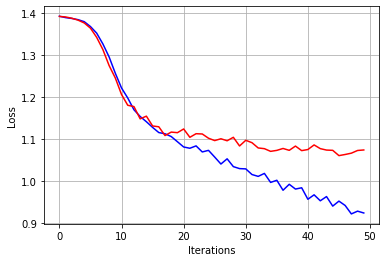

In [217]:
my_MLP2 = MLP_3layer_train(input_size=300, hidden1 = 32, hidden2 = 16, hidden3=8,
                        output_size = 4, drop=0.1)


my_MLP2.fit(x_train,x_val,y_train,y_val,epochs=50)

plt.plot(my_MLP2.loss_during_training,label='Training Cross Entropy Loss', color = 'blue')
plt.plot(my_MLP2.valid_loss_during_training,label='validation Cross Entropy Loss', color = 'red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

In [218]:
logprobs,acc = my_MLP2.score(x_test, y_test)

probs = np.exp(logprobs)  

print(f"The test accuracy is {acc}")

The test accuracy is 0.4919642857142857


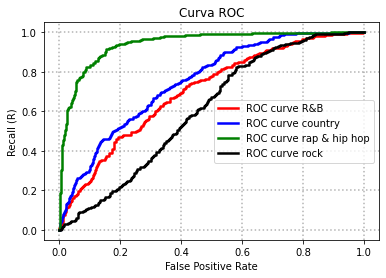

AUC ROC for MLP2 is 0.7524


In [219]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for MLP2 is {area_roc:.4f}")

It is even worse! Compared to other NN we have developed in the other course at least these MLPs are more robust to overfit. Furthermore clearly the implementation of a new layer to reduce the dropout does not worked unfortunatelly. 

Our expectations over these MLPs were higher than what we get returned because in the course of NN we have also created one of this over a NLP dataset and its accuracy were much higher. Obiously the dataset always is very important in the final result, but I do not know, I was expecting more especially based on what we saw in class :(

##### **2.1.2.2 Recurrent Neural Network (RNN)**

Obiously we could not leave this Deep Learning approach without trying recurrent neural networks before. However, none of the models will be useful because all we have tried is already computting the mean of the embbedings and LSTM layers if is characterized by something is the perception of context which is totally loss when we use the mean. 

Again I would like to thank my NN course which help us to develop this kind of network which hopefully it is able to overperform other classification models we have seen previously.

First we need to do is generate the datasets, and it will not be straight forward as we will see:

In [395]:
lengths = np.array([len(d) for d in corpus])
np.sum(lengths > 500)

150

We need to create equal length songs in order to create our vectors of the same shape. For doing so, we are going to introduce 'garbage tokens' in those songs which does not fulfill thw minimum size which will be established at 500 words. Therefore, we are going to remove those elements which overcome this value and insert a 'garbage token inside'.

In [396]:
def insertGarbage(doc, limit):
    toins = limit - len(doc)
    for _ in range(toins):
        doc.append('ñ')
    return doc

rnn_corpus_u500 = [doc for doc in corpus if len(doc) < 500] 
rnn_corpus_u500_idx = [i for i,doc in enumerate(corpus) if len(doc) < 500]
lengths_corpus = [len(d) for d in rnn_corpus_u500]
limit = max(lengths_corpus)
rnn_corpus = [insertGarbage(doc.copy(),limit) for doc in rnn_corpus_u500] 

This will be our definitive corpus, now it is the moment to compute the embeddings of each word, for doing so we will use the pre-trained fastText model we prepare previously:

In [397]:
docsEmb = np.array([[fastTextPre[w] for w in doc] for doc in rnn_corpus])

docsEmb.shape

(3579, 499, 300)

It is looking good, the shape of our matrix is (numDocs,maxlen,embeddingVec)

Without more introduction, let's generate the training, testing and validation set:

In [398]:
Y = df.iloc[rnn_corpus_u500_idx]['type'].values

# Discretize 'string' variables using sklearn
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

idx_data = np.arange(0,len(rnn_corpus),1) #Our corpus indices

# Train and Test
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, Y, test_size=0.3, random_state=33)
# Validation Set from Training Set
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.3, random_state=33)

Once we have defined the corpus indexes for each set it is the moment to after generating the embbedings of each word in the corpus, properly define the sets:

In [399]:
#Train
x_train = docsEmb[idx_train]
len_train = np.array(lengths_corpus)[idx_train]
#Test
x_test = docsEmb[idx_test]
len_test = np.array(lengths_corpus)[idx_test]
#Validation
x_val = docsEmb[idx_val]
len_val = np.array(lengths_corpus)[idx_val]

print(len(len_train) + len(x_test) + len(x_val))

3579


We already have defined the training and testing sets and the lengths of each document it is the moment to define our RNN:

In [400]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop=0.0):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        
        # LSTM layer
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, 
                          nonlinearity='relu',batch_first=True)
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size) 
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        self.dropout = nn.Dropout(p=drop)

    def forward(self, x, lengths, h0=None):
        batch_size = x.size(0)
        
        r_out, _ = self.rnn(x, h0)
        
        
        aux = torch.mean(r_out, 1)
        
        #Return the state of the last non-garbage token (Tried but did not figure out as expected)
        # aux = torch.stack([r_out[[d], lengths[d] - 1,:] for d in range(batch_size)]).reshape([-1,self.hidden_dim])
        drop = self.dropout(aux) 
        output = self.logsoftmax(self.fc1(drop))
        return output


class RNN_train(RNN):
    def __init__(self,input_size, output_size, hidden_dim, n_layers,drop=0.0,batch_size=50,lr=0.0005, reg_lambda = 0.001):
        super().__init__(input_size, output_size, hidden_dim, n_layers, drop)  
        self.lr = lr # Learning Rate
        self.reg_lambda = reg_lambda
        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer
        self.criterion = nn.NLLLoss()    
                   
        self.loss_during_training = [] 
        self.valid_loss_during_training = [] 
        
        self.batch_size = batch_size
        
    def score(self,x_test,len_test,Y=None):
        x_test = torch.Tensor(x_test)
        accuracy = 0.0 
          
        with torch.no_grad():    
            logprobs = self.forward(x_test,len_test).detach().numpy()   
            if(len(Y)>0): 
                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]
        return logprobs,accuracy
            
        
    def fit(self,x_train,x_val,y_train,y_val,len_train,len_val,epochs=100):
        self.epochs=epochs
        
        x_train = torch.Tensor(x_train)
        x_val = torch.Tensor(x_val)
        labels = torch.Tensor(y_train).type(torch.LongTensor) # Training labels
        labelsval = torch.Tensor(y_val).type(torch.LongTensor) # Validation labels
        
        self.num_train = len(x_train) # Number of training points
        self.num_batchs = np.floor(self.num_train/self.batch_size) # Number of training batches
        self.num_val = len(x_val) # Number of validation points
        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numero of validating batches
        
        for e in tqdm(range(int(self.epochs))):
            self.train() # Activate dropout
            # Random data permutation
            idx = np.random.permutation(self.num_train)
            running_loss = 0.
            
            for i in range(int(self.num_batchs)):
                self.optim.zero_grad()  
                # Indices of the data entering the batch
                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
                # We compute the classifier output for every data
                out = self.forward(x_train[idx_batch],[len_train[d] for d in idx_batch])
                # Cost function and gradient descent step
                loss = self.criterion(out,labels[idx_batch])+ self.reg_lambda*torch.norm(self.fc1.weight)
                running_loss += loss.item()
                loss.backward()
                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0) 
                # SGD steps 
                self.optim.step()
                
            self.loss_during_training.append(running_loss/self.num_batchs)
            
            # We repeat for validation
            
            with torch.no_grad():                 
                # set model to evaluation mode
                self.eval()  
                idx = np.random.permutation(self.num_val)
                running_loss = 0.
                
                for i in range(int(self.num_batchs_val)):
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size] 
                    out = self.forward(x_val[idx_batch],[len_val[d] for d in idx_batch])                   
                    loss = self.criterion(out,labelsval[idx_batch]) + self.reg_lambda*torch.norm(self.fc1.weight)                
                    running_loss += loss.item() 
                    
                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)    
                    

Detais will be deeply explained in the report but overall we have defined a RNN with a LSTM layer and finally a linear layer for the classification by song genre. Then, it is the moment of training our RNN and let's see the results this network is providing us:

In [401]:
my_RNN = RNN_train(input_size = 300, output_size = 4, hidden_dim = 20, n_layers = 2, 
                   drop = 0.7)

my_RNN.fit(x_train,x_val,y_train,y_val,len_train, len_val, epochs = 100) 

100%|██████████| 100/100 [30:05<00:00, 18.06s/it]


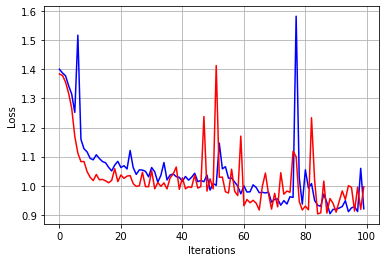

In [402]:
plt.plot(my_RNN.loss_during_training,label='Training Cross Entropy Loss', color = 'blue')
plt.plot(my_RNN.valid_loss_during_training,label='validation Cross Entropy Loss', color = 'red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

Above plot is essential to check overfitting, if it is quite clear, you need to change things if you wnat to obtain the best accuracy as possible. As that it what I did, adding regularization to control better the loss and especially dropout at a very high level to easy the work of the final layer. After some trial and error, I think this is the best we could do. Let's have a look on the accuracy:

In [403]:
logprobs,acc = my_RNN.score(x_test, len_test, y_test)

probs = np.exp(logprobs)  

print(f"The test accuracy is {acc}")

The test accuracy is 0.5791433891992551


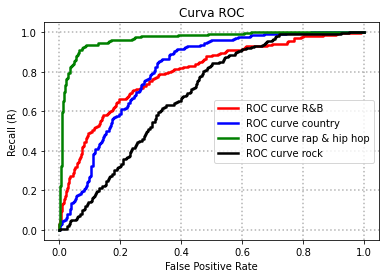

AUC ROC for RNN is 0.8134


In [404]:
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for RNN is {area_roc:.4f}")

This network seems to be better than all the classifiers we have used at least for the fastText model. We have tried for many different values and this time we are able to execute several epochs without overfitting which always is great. Regarding ROC curve, is amazing the area which is over 0.8 and especially for ``rap & hip hop`` which is almost perfect it classification.